#__Modelo de predicción de bajo costo del estado nutricional de niños menores de 5 años en Colombia basado en la encuesta Rapid SMART 2023__

# Fase I. Obtención y procesamiento de datos

## __Contenido__

> Análisis exploratorio
>>1. Contexto de la data
>>2. Análisis descriptivo
>>3. Análisis univariado
>>>* Distribución de variables numéricas
>>>* Datos atípicos y datos faltantes
>>>* Datos estadísticos (Histotograma, media, moda)
>>>* Distribución ajustada

> Análisis bivariado
>>1. Gráficos bivariados (cruce con variables categóricas)
>>2. Análisis de correlación lineal
>>3. Relaciones entre varibales númericas y categóricas

> Modelos predictivos
>>1. Modelo 1
>>2. Modelo 2
>>2. Modelo 3
>---

## __Análisis exploratorio__

### 1. __Contexto de la data__

El conjunto de datos corresponde a la información de la encuesta SMART que es un método de encuesta mejorado que equilibra la simplicidad (para una evaluación rápida de emergencias graves) y la solidez técnica. Se basa en los elementos centrales de varias metodologías con actualizaciones continúas fundadas en investigación y en las mejores prácticas actuales.

La Metodología SMART se basa en los dos indicadores de salud pública más vitales y básicos para evaluar la magnitud de la gravedad de una crisis humanitaria:

Estado nutricional de los niños y niñas menores de cinco años
Tasa de mortalidad de la población
​Estos indicadores son útiles para priorizar los recursos, así como para monitorear en qué medida el sistema de asistencia está cubriendo las necesidades de la población y, por lo tanto, el impacto general de la respuesta de asistencia.

SMART garantiza que los datos de las encuestas sean consistentes y confiables y que se recopilen y analicen utilizando una metodología única y estandarizada. Asimismo, proporciona capacidad técnica para la toma de decisiones y la elaboración de reportes, y un apoyo integral para el desarrollo estratégico y continuo de capacidades.

La Metodología SMART busca reformar y unificar las evaluaciones y las respuestas a las emergencias para la vigilancia (en caso de que se utilicen en intervalos de tiempo iguales). De igual forma, asegura que las decisiones de políticas y programas se basen en datos confiables y estandarizados y que se proporcione ayuda humanitaria a quienes más la necesitan.

### 2. Análisis descriptivo

In [ ]:
# Importación de Librerías
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import collections
from collections import Counter
import plotly.express as px
import os
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import base64
from io import BytesIO

In [ ]:
# Configuración [Datos no públicos]
usuario = ""
repo = ""
ruta_archivo = ""
token = ""

# Descargar usando la API
url = f"https://api.github.com/repos/{usuario}/{repo}/contents/{ruta_archivo}"
headers = {"Authorization": f"token {token}"}
response = requests.get(url, headers=headers)
content = response.json()["content"]

# Decodificar contenido (está en base64)
import base64
decoded = base64.b64decode(content)

# Guardar como archivo Excel
with open("SMART_COL_2023.xlsx", "wb") as f:
    f.write(decoded)

# Cargar las hojas
all_sheets = pd.read_excel("SMART_COL_2023.xlsx", sheet_name=None)

In [ ]:
# Importación de tablas nutricionales WHZ de la OMS
# Fuente: https://www.who.int/tools/child-growth-standards/standards/weight-for-length-height

archivos = {
    "data/wfl_boys_0-to-2-years_zscores.xlsx": "lms_boys_0_2",
    "data/wfl_girls_0-to-2-years_zscores.xlsx": "lms_girls_0_2",
    "data/wfh_boys_2-to-5-years_zscores.xlsx": "lms_boys_2_5",
    "data/wfh_girls_2-to-5-years_zscores.xlsx": "lms_girls_2_5"
}
# Diccionario para almacenar los DataFrames de cada archivo
dfs = {}

for ruta_archivo, nombre_df in archivos.items():
    try:
        # Descargar el archivo desde GitHub
        url = f"https://api.github.com/repos/{usuario}/{repo}/contents/{ruta_archivo}"
        headers = {"Authorization": f"token {token}"}
        response = requests.get(url, headers=headers)
        response.raise_for_status()

        # Decodificar y leer el Excel
        content = base64.b64decode(response.json()["content"])
        df = pd.read_excel(BytesIO(content))

        # Asignar el DataFrame a una variable global con el nombre deseado
        globals()[nombre_df] = df
        dfs[nombre_df] = df  # Opcional: guardar en diccionario

        print(f"✅ Archivo '{ruta_archivo}' cargado como '{nombre_df}'. Shape: {df.shape}")
    except Exception as e:
        print(f"❌ Error al cargar '{ruta_archivo}': {str(e)}")

✅ Archivo 'data/wfl_boys_0-to-2-years_zscores.xlsx' cargado como 'lms_boys_0_2'. Shape: (131, 11)
✅ Archivo 'data/wfl_girls_0-to-2-years_zscores.xlsx' cargado como 'lms_girls_0_2'. Shape: (131, 11)
✅ Archivo 'data/wfh_boys_2-to-5-years_zscores.xlsx' cargado como 'lms_boys_2_5'. Shape: (111, 11)
✅ Archivo 'data/wfh_girls_2-to-5-years_zscores.xlsx' cargado como 'lms_girls_2_5'. Shape: (111, 11)


Creación de dataframes a partir de las hojas de excel de la encuesta SMART

In [ ]:
df_hogar = all_sheets['SMART HOGAR']
df_fallecimientos = all_sheets['FALLECIMIENTOS']
df_plw = all_sheets['GEST-LACT']
df_miembros = all_sheets['MIEMBROS']
df_ninos = all_sheets['NIÑOS']
df_no_miembros = all_sheets['NO MIEMBROS']

In [ ]:
# Lista de DataFrames y sus nombres de hoja
dataframes = {
    'df_hogar': 'SMART HOGAR',
    'df_fallecimientos': 'FALLECIMIENTOS',
    'df_plw': 'GEST-LACT',
    'df_miembros': 'MIEMBROS',
    'df_ninos': 'NIÑOS',
    'df_no_miembros': 'NO MIEMBROS'
}

# Crear la lista de resumen
summary_data = []
for df_name, sheet_name in dataframes.items():
    df = all_sheets[sheet_name]
    summary_data.append([df_name, sheet_name, df.shape[1], df.shape[0]])

# Crear el DataFrame resumen
summary_df = pd.DataFrame(summary_data, columns=['DF', 'Descripción', 'Número de Columnas', 'Número de registros'])

# Mostrar la tabla resumen
display(summary_df)

,DF,Descripción,Número de Columnas,Número de registros
0,df_hogar,SMART HOGAR,114,1147
1,df_fallecimientos,FALLECIMIENTOS,15,6
2,df_plw,GEST-LACT,36,125
3,df_miembros,MIEMBROS,23,3514
4,df_ninos,NIÑOS,162,459
5,df_no_miembros,NO MIEMBROS,13,94


Luego de revisar y constatar con el personal implementador de la encuesta se logra validar que las tablas "fallecimientos" y "no miembros" solo es información de soporte, dado que esta información en su resumen que define el número de personas fallecidas en el hogar y el numero de personas que no eran miembros del hogar en el priorodo de referencia o periodo de la evaluación, están contidos en la tabla "SMART HOGAR", en las siguientes columnas:
>* selected/Sección 1: COMPOSICION DEL HOGAR Y MORTALIDAD/¿Cuál es el número total de miembros del hogar que **ya NO hacen parte de este hogar** durante el período de referencia?
>* selected/Sección 1: COMPOSICION DEL HOGAR Y MORTALIDAD/numdeath

Por tanto, estas dos tablas se excluirán del datasetfinal.

> #### Dataframe SMART HOGAR

Este dataframe contiene la información principal de los hogares encuestados, incluyendo datos de ubicación, identificación, composición familiar, seguridad alimentaria, acceso a agua y saneamiento, estrategias de afrontamiento y estado nutricional del hogar.

In [ ]:
display(df_hogar.head(5))

,start,end,deviceid,rand,Sección 0: DATOS DE IDENTIFICACION Y CONSENTIMIENTO/Sector,Sección 0: DATOS DE IDENTIFICACION Y CONSENTIMIENTO/Departamento (Municipio),Sección 0: DATOS DE IDENTIFICACION Y CONSENTIMIENTO/Nombre del corregimiento/vereda/Consejo comunitario afrodescendiente/Resguardo indigena,Sección 0: DATOS DE IDENTIFICACION Y CONSENTIMIENTO/Número de Conglomerado:,Sección 0: DATOS DE IDENTIFICACION Y CONSENTIMIENTO/Conglomerado de Reserva,Sección 0: DATOS DE IDENTIFICACION Y CONSENTIMIENTO/Número de equipo,...,total_measured,total_malnourished,total_referred,percent_childmeasured,__version__,_id,_uuid,_submission_time,_validation_status,_index
0,2023-10-11T15:06:20.548-05:00,2023-10-12T15:16:30.729-05:00,collect:H5ar7VszmiHntJn7,0.067930,Cabecera Municipal,Norte Santander (Tibú),La Gabarra,118,NaN,6,...,0,0,0,NaN,NaN,324697,15181db5-9ad0-4f46-880a-37bf9b1840fb,2023-10-12T20:17:57,NaN,1
1,2023-10-11T15:46:26.710-05:00,2023-10-12T15:17:44.858-05:00,collect:H5ar7VszmiHntJn7,0.486476,Cabecera Municipal,Norte Santander (Tibú),La Gabarra,118,NaN,6,...,1,0,0,100.0,NaN,324698,2a0a480a-1378-45d5-8213-90ed9e3f83c1,2023-10-12T20:17:58,NaN,2
2,2023-10-12T08:08:10.016-05:00,2023-10-12T15:09:45.849-05:00,collect:hVwWT7Nrvo1hwSBQ,0.186090,Cabecera Municipal,Norte Santander (Tibú),La gabarra,118,NaN,7,...,2,0,0,100.0,NaN,324701,42a27734-dd38-4690-bdf3-b3194d5bb816,2023-10-12T20:18:31,NaN,3
3,2023-10-12T08:27:59.832-05:00,2023-10-12T15:15:21.506-05:00,collect:hVwWT7Nrvo1hwSBQ,0.232496,Cabecera Municipal,Norte Santander (Tibú),La gabarra,118,NaN,7,...,2,0,0,100.0,NaN,324703,ed52f7c8-6cce-4751-9c6b-1b742707ca1b,2023-10-12T20:18:33,NaN,4
4,2023-10-12T08:43:32.564-05:00,2023-10-12T15:16:35.701-05:00,collect:hVwWT7Nrvo1hwSBQ,0.807421,Cabecera Municipal,Norte Santander (Tibú),La gabarra,118,NaN,7,...,0,0,0,NaN,NaN,324705,d04f1efa-6da8-4bfa-98a4-4257f94012bf,2023-10-12T20:18:35,NaN,5


In [ ]:
# Crear un diccionario que mapea los nombres de las variables de hogar
dicc_hogar = {col: f"Hog_{i+1}" for i, col in enumerate(df_hogar.columns)}

# Renombrar las columnas en el DataFrame
df_hogar.rename(columns=dicc_hogar, inplace=True)

# Convertir el diccionario en un DataFrame para facilitar su consulta o guardado
df_dicc_hogar = pd.DataFrame(list(dicc_hogar.items()), columns=["Columna_Original", "Columna_Nueva"])

In [ ]:
# Elimimos variables que no aportan al análsis de los datos
# Lista de columnas a eliminar
columnas_a_eliminar = ['Hog_1', 'Hog_2', 'Hog_3', 'Hog_4', 'Hog_8', 'Hog_9', 'Hog_10',
                        'Hog_11', 'Hog_12', 'Hog_13', 'Hog_14', 'Hog_15', 'Hog_17', 'Hog_19',
                        'Hog_21', 'Hog_22', 'Hog_24', 'Hog_25', 'Hog_26', 'Hog_27',
                        'Hog_28', 'Hog_29', 'Hog_31', 'Hog_32', 'Hog_33', 'Hog_34',
                        'Hog_35', 'Hog_36', 'Hog_37', 'Hog_38', 'Hog_39', 'Hog_40',
                        'Hog_41', 'Hog_42', 'Hog_43', 'Hog_44', 'Hog_45', 'Hog_47',
                        'Hog_48', 'Hog_49', 'Hog_50', 'Hog_51', 'Hog_52', 'Hog_53',
                        'Hog_54', 'Hog_55', 'Hog_56', 'Hog_57', 'Hog_58', 'Hog_60',
                        'Hog_61', 'Hog_62', 'Hog_82', 'Hog_83', 'Hog_85', 'Hog_86',
                        'Hog_87', 'Hog_88', 'Hog_89', 'Hog_90', 'Hog_91', 'Hog_93',
                        'Hog_95', 'Hog_96', 'Hog_97', 'Hog_98', 'Hog_99', 'Hog_100',
                        'Hog_102', 'Hog_103', 'Hog_104', 'Hog_105', 'Hog_106',
                        'Hog_107', 'Hog_108', 'Hog_109', 'Hog_111', 'Hog_112', 'Hog_113']

# Filtrar solo las columnas que existen en df_hogar
columnas_existentes = [col for col in columnas_a_eliminar if col in df_hogar.columns]

# Eliminar solo las columnas existentes
df_hogar.drop(columns=columnas_existentes, inplace=True)


In [ ]:
# Filtramos los rigristros que fueron marcado en como encuesta completada 100% [variable 101]
df_hogar = df_hogar[df_hogar['Hog_101'] == "Encuestado 100%"]

#Eliminamos registros duplicados si existen
df_hogar = df_hogar.drop_duplicates()

In [ ]:
# Diccionario con el mapeo de nombres específicos
mapeo_nombres = {
    'Hog_5': 'sector', 'Hog_6': 'municipio', 'Hog_7': 'zona',
    'Hog_16': 'numero_familia', 'Hog_18': 'numero_ninos', 'Hog_20': 'numero_mujeres',
    'Hog_23': 'numero_no_miembros', 'Hog_30': 'mumero_fallecidos', 'Hog_46': 'indicador_hdds',
    'Hog_59': 'indicador_rcsi', 'Hog_63': 'lcsi_vende_bienes', 'Hog_64': 'lcsi_gasta_ahorros',
    'Hog_65': 'lcsi_vende_animales', 'Hog_66': 'lcsi_come_fuera', 'Hog_67': 'lcsi_alimentos_prestados',
    'Hog_68': 'lcsi_dinero_prestado', 'Hog_69': 'lcsi_cambio_escuela', 'Hog_70': 'lcsi_vende_activos',
    'Hog_71': 'lcsi_retiro_escuela', 'Hog_72': 'lcsi_redujo_gastos', 'Hog_73': 'lcsi_cultivos_inmaduros',
    'Hog_74': 'lcsi_consume_reservas', 'Hog_75': 'lcsi_gastos_fertilizantes', 'Hog_76': 'lcsi_patrimonio',
    'Hog_77': 'lcsi_mendigar', 'Hog_78': 'lcsi_otras_actividades', 'Hog_79': 'lcsi_ganado',
    'Hog_80': 'lcsi_emigro_hogar', 'Hog_81': 'wash_acceso_agua', 'Hog_84': 'wash_no_tratamiento',
    'Hog_92': 'wash_acceso_higiene', 'Hog_94': 'wash_no_practicas_higiene', 'Hog_101': 'estado_encuesta',
    'Hog_110': 'id_hogar', 'Hog_114': 'index_hogar'
}

# Renombrar las columnas en df_hogar
df_hogar.rename(columns=mapeo_nombres, inplace=True)


In [ ]:
import pandas as pd

# Definir la clasificación de cada estrategia según su nivel de gravedad
clasificacion_lcsi = {
    "Estrategias de Estrés": [
        "lcsi_gasta_ahorros",
        "lcsi_alimentos_prestados",
        "lcsi_dinero_prestado",
        "lcsi_redujo_gastos",
        "lcsi_consume_reservas",
        "lcsi_gastos_fertilizantes",
    ],
    "Estrategias de Crisis": [
        "lcsi_vende_bienes",
        "lcsi_vende_animales",
        "lcsi_cultivos_inmaduros",
        "lcsi_patrimonio",
        "lcsi_ganado",
    ],
    "Estrategias de Emergencia": [
        "lcsi_retiro_escuela",
        "lcsi_cambio_escuela",
        "lcsi_mendigar",
        "lcsi_vende_activos",
        "lcsi_emigro_hogar",
        "lcsi_otras_actividades",
    ],
}

# Definir el orden de gravedad (de menor a mayor)
niveles_gravedad = {
    "Ninguna": 0,
    "Estrategias de Estrés": 1,
    "Estrategias de Crisis": 2,
    "Estrategias de Emergencia": 3,
}

# Crear una función para determinar el nivel máximo de gravedad por fila
def clasificar_lcsi(fila):
    nivel_maximo = "Ninguna"
    max_puntaje = 0
    for categoria, variables in clasificacion_lcsi.items():
        # Verificar si alguna variable de la categoría tiene "Sí"
        if any(fila[var] == "Sí" for var in variables if var in fila):
            puntaje = niveles_gravedad[categoria]
            if puntaje > max_puntaje:
                max_puntaje = puntaje
                nivel_maximo = categoria
    return nivel_maximo

# Aplicar la función al DataFrame para crear la columna "LCSI"
df_hogar["LCSI"] = df_hogar.apply(clasificar_lcsi, axis=1)

In [ ]:
# Lista de columnas a eliminar
columnas_a_eliminar = [
    "lcsi_gasta_ahorros",
    "lcsi_vende_animales",
    "lcsi_come_fuera",
    "lcsi_alimentos_prestados",
    "lcsi_dinero_prestado",
    "lcsi_cambio_escuela",
    "lcsi_vende_activos",
    "lcsi_retiro_escuela",
    "lcsi_redujo_gastos",
    "lcsi_cultivos_inmaduros",
    "lcsi_consume_reservas",
    "lcsi_gastos_fertilizantes",
    "lcsi_patrimonio",
    "lcsi_mendigar",
    "lcsi_otras_actividades",
    "lcsi_ganado",
    "lcsi_emigro_hogar",
    "lcsi_vende_bienes",
]

# Eliminar las columnas del DataFrame
df_hogar = df_hogar.drop(columns=columnas_a_eliminar)

Ajustes en las variables de Agua, higiene y saneamiento (WASH)
1. Se Simplifica las opciones de acceso a agua
2. Se transforma la variable de no tramiento del agua, a cuales hogares "Sí" o "No" realizan tramiento de aguas
3. Se transforma la variable de no prácticas de higiene, a cuales hogares "Sí" o "No" realizan prácticas de higiene en la prepración de los alimentos

In [ ]:
# Definir el diccionario de mapeo
mapeo_agua = {
    "Acueducto (servicio público)": "Acueducto",
    "Fuente de agua subterránea (pozo con extracción manual, pozo con bomba, puntillo)": "Fuente de agua subterránea",
    "Fuente de agua superficial (río, quebrada, nacimiento)": "Fuente de agua superficial",
}

# Aplicar el mapeo a la columna
df_hogar["wash_acceso_agua"] = df_hogar["wash_acceso_agua"].replace(mapeo_agua)

# Renombrar las columnas
df_hogar = df_hogar.rename(columns={
    "wash_no_practicas_higiene": "wash_practicas_higiene",
    "wash_no_tratamiento": "wash_tratamiento"
})

# Cambiar los valores: 0 → "Sí", 1 → "No"
df_hogar["wash_practicas_higiene"] = df_hogar["wash_practicas_higiene"].replace({0: "Sí", 1: "No"})
df_hogar["wash_tratamiento"] = df_hogar["wash_tratamiento"].replace({0: "Sí", 1: "No"})

In [ ]:
# Verificar las columnas restantes
print(df_hogar.columns)

Index(['sector', 'municipio', 'zona', 'numero_familia', 'numero_ninos',
       'numero_mujeres', 'numero_no_miembros', 'mumero_fallecidos',
       'indicador_hdds', 'indicador_rcsi', 'wash_acceso_agua',
       'wash_tratamiento', 'wash_acceso_higiene', 'wash_practicas_higiene',
       'estado_encuesta', 'id_hogar', 'index_hogar', 'LCSI'],
      dtype='object')


,Métrica,Antes,Después
0,Número de columnas,114,18
1,Número de registros,1147,886


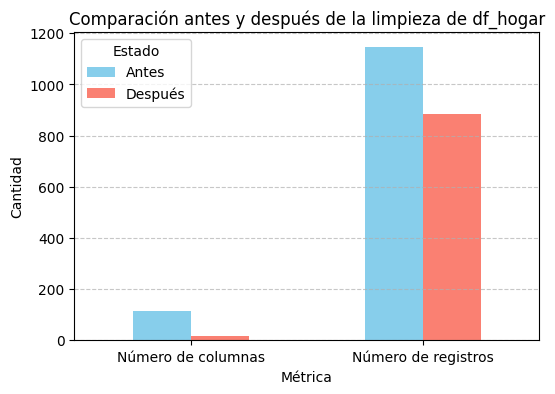

In [ ]:
# Obtener valores originales de df_hogar desde summary_df
original_cols = summary_df.loc[summary_df["DF"] == "df_hogar", "Número de Columnas"].values[0]
original_rows = summary_df.loc[summary_df["DF"] == "df_hogar", "Número de registros"].values[0]

# Crear DataFrame de comparación
comparison_df = pd.DataFrame({
    "Métrica": ["Número de columnas", "Número de registros"],
    "Antes": [original_cols, original_rows],
    "Después": [df_hogar.shape[1], df_hogar.shape[0]]
})

# Mostrar la tabla
display(comparison_df)

# Graficar la comparación
fig, ax = plt.subplots(figsize=(6, 4))
comparison_df.set_index("Métrica").plot(kind="bar", ax=ax, color=["skyblue", "salmon"])
plt.title("Comparación antes y después de la limpieza de df_hogar")
plt.ylabel("Cantidad")
plt.xticks(rotation=0)
plt.legend(title="Estado")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Mostrar el gráfico
plt.show()

> #### Dataframe GEST-LACT

El estado nutricional de las mujeres lactantes y gestantes en el hogar es muy importante ya que influye en su salud como en la del bebé, causando en este bajo peso al nacer, en la lactancia materna una nutrición deficiente puede afectar la calidad y cantidad de leche limitando los nutrientes escenciales para el crecimiento del bebé. Este dataframe Contiene información detallada sobre mujeres gestantes y lactantes, incluyendo:
* ✔️ Medidas antropométicas de la lactante y/o gestante
* ✔️ Acceso a controles prenatales y servicios de salud.
* ✔️ Prácticas de lactancia y alimentación materna.
* ✔️ Diversidad Dietética Mínima en Mujeres

In [ ]:
display(df_plw.head(5))

,selected/Sección 3 Mujeres Gestantes y lactantes/women_selected_position,selected/Sección 3 Mujeres Gestantes y lactantes/women_hh_position,selected/Sección 3 Mujeres Gestantes y lactantes/women_name,selected/Sección 3 Mujeres Gestantes y lactantes/women_age_years,selected/Sección 3 Mujeres Gestantes y lactantes/CHSEX2,selected/Sección 3 Mujeres Gestantes y lactantes/Introduzca ahora los datos la mujer: ${women_name} (${CHSEX2}) con edad en años: ${women_age_years},selected/Sección 3 Mujeres Gestantes y lactantes/Estado actual de la mujer:,selected/Sección 3 Mujeres Gestantes y lactantes/¿En su último o actual embarazo ha sido atendida en controles prenatales?,selected/Sección 3 Mujeres Gestantes y lactantes/¿En su último o actual embarazo ha recibido suplemento (acido folico y/o hierro)?,selected/Sección 3 Mujeres Gestantes y lactantes/MDDW (Diversidad Dietética Mínima en Mujeres)/Ahora quisiera preguntarle sobre los tipos de alimentos que usted ha consumido (en las últimas 24 horas) durante el día y la noche:,...,selected/Sección 3 Mujeres Gestantes y lactantes/MDDW (Diversidad Dietética Mínima en Mujeres)/Diversidad alimentaria de la mujer en edad fertil: ${indicador_MDDW},selected/Sección 3 Mujeres Gestantes y lactantes/Perímetro braquial de ${women_name} en mm,_index,_parent_table_name,_parent_index,_submission__id,_submission__uuid,_submission__submission_time,_submission__validation_status,Unnamed: 35
0,0,1.0,IR-H324698-M40,40,Mujer,NaN,Lactante,Sí,Sí,NaN,...,NaN,417.0,1,Encuesta SMART Colombia,2,324698,2a0a480a-1378-45d5-8213-90ed9e3f83c1,2023-10-12T20:17:58,NaN,NaN
1,0,1.0,YO-H324710-M27,27,Mujer,NaN,Lactante,Sí,Sí,NaN,...,NaN,257.0,2,Encuesta SMART Colombia,8,324710,e12560f3-a58b-40cd-b0e3-1d7e3559f04f,2023-10-12T20:18:51,NaN,NaN
2,0,1.0,JE-H324806-M28,28,Mujer,NaN,Gestante,Sí,Sí,NaN,...,NaN,230.0,3,Encuesta SMART Colombia,30,324806,e1cff7f6-bb33-4971-a3e5-bd0569c67f8c,2023-10-12T20:49:12,NaN,NaN
3,0,5.0,YA-H324807-M30,30,Mujer,NaN,Lactante,Sí,No,NaN,...,NaN,301.0,4,Encuesta SMART Colombia,31,324807,1b639c1d-994b-4e7f-ac48-9378171a2868,2023-10-12T20:49:13,NaN,NaN
4,0,1.0,EM-H324809-M19,19,Mujer,NaN,Lactante,No,Sí,NaN,...,NaN,266.0,5,Encuesta SMART Colombia,33,324809,1ef1527b-7053-4c67-bf08-ae9b25474376,2023-10-12T20:49:15,NaN,NaN


In [ ]:
# Crear un diccionario que mapea los nombres de las variables de mujeres gestantes y/o lactantes
dicc_plw = {col: f"Plw_{i+1}" for i, col in enumerate(df_plw.columns)}

# Renombrar las columnas en el DataFrame
df_plw.rename(columns=dicc_plw, inplace=True)

# Convertir el diccionario en un DataFrame para facilitar su consulta o guardado
df_dicc_plw = pd.DataFrame(list(dicc_plw.items()), columns=["Columna_Original", "Columna_Nueva"])

In [ ]:
# Elimimos variables que no aportan al análsis de los datos
# Lista de columnas a eliminar
columnas_a_eliminar = ['Plw_1', 'Plw_2', 'Plw_3', 'Plw_6', 'Plw_10', 'Plw_11',
                       'Plw_12', 'Plw_13', 'Plw_14', 'Plw_15', 'Plw_16', 'Plw_17',
                       'Plw_18', 'Plw_19', 'Plw_20', 'Plw_21', 'Plw_22', 'Plw_23',
                       'Plw_24', 'Plw_25', 'Plw_27', 'Plw_30', 'Plw_33', 'Plw_34', 'Plw_35','Plw_36']

# Filtrar solo las columnas que existen en df_hogar
columnas_existentes = [col for col in columnas_a_eliminar if col in df_plw.columns]

# Eliminar solo las columnas existentes
df_plw.drop(columns=columnas_existentes, inplace=True)

In [ ]:
display(df_plw.head(5))

,Plw_4,Plw_5,Plw_7,Plw_8,Plw_9,Plw_26,Plw_28,Plw_29,Plw_31,Plw_32
0,40,Mujer,Lactante,Sí,Sí,3,417.0,1,2,324698
1,27,Mujer,Lactante,Sí,Sí,3,257.0,2,8,324710
2,28,Mujer,Gestante,Sí,Sí,4,230.0,3,30,324806
3,30,Mujer,Lactante,Sí,No,3,301.0,4,31,324807
4,19,Mujer,Lactante,No,Sí,5,266.0,5,33,324809


In [ ]:
# Diccionario con el mapeo de nombres específicos
mapeo_nombres = {'Plw_4' : 'edad_anio', 'Plw_5' : 'sexo', 'Plw_7' : 'estado',
                 'Plw_8' : 'controles', 'Plw_9' : 'suplemento',
                 'Plw_26' : 'indicador_mddw', 'Plw_28' : 'pb_plw',
                 'Plw_29' : 'index_plw', 'Plw_31' : 'index_hogar', 'Plw_32' : 'id_hogar'
}

# Renombrar las columnas en df_hogar
df_plw.rename(columns=mapeo_nombres, inplace=True)


In [ ]:
display(df_plw.head(5))

,edad_anio,sexo,estado,controles,suplemento,indicador_mddw,pb_plw,index_plw,index_hogar,id_hogar
0,40,Mujer,Lactante,Sí,Sí,3,417.0,1,2,324698
1,27,Mujer,Lactante,Sí,Sí,3,257.0,2,8,324710
2,28,Mujer,Gestante,Sí,Sí,4,230.0,3,30,324806
3,30,Mujer,Lactante,Sí,No,3,301.0,4,31,324807
4,19,Mujer,Lactante,No,Sí,5,266.0,5,33,324809


In [ ]:
#Se filtan los registros de mujeres gestantes/lactante de acuerdo con los hogares finales
df_plw = df_plw.merge(df_hogar[['index_hogar']], on='index_hogar', how='inner')

# Filtrar por sexo igual a "Mujer"
df_plw = df_plw[df_plw['sexo'] == 'Mujer']

# Eliminar filas donde la columna 'estado' tenga valores vacíos
df_plw = df_plw[df_plw['estado'].notna()]


,Métrica,Antes,Después
0,Número de columnas,36,10
1,Número de registros,125,122


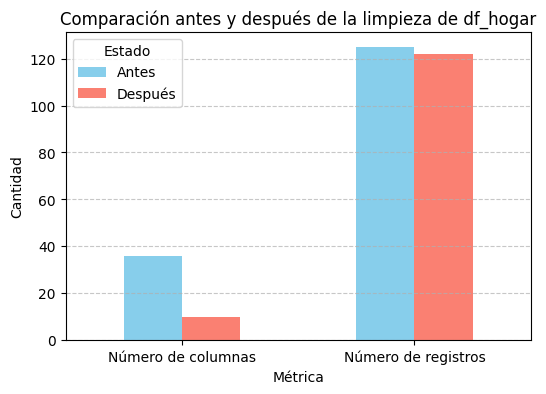

In [ ]:
# Obtener valores originales de df_plw desde summary_df
original_cols = summary_df.loc[summary_df["DF"] == "df_plw", "Número de Columnas"].values[0]
original_rows = summary_df.loc[summary_df["DF"] == "df_plw", "Número de registros"].values[0]

# Crear DataFrame de comparación
comparison_df = pd.DataFrame({
    "Métrica": ["Número de columnas", "Número de registros"],
    "Antes": [original_cols, original_rows],
    "Después": [df_plw.shape[1], df_plw.shape[0]]
})

# Mostrar la tabla
display(comparison_df)

# Graficar la comparación
fig, ax = plt.subplots(figsize=(6, 4))
comparison_df.set_index("Métrica").plot(kind="bar", ax=ax, color=["skyblue", "salmon"])
plt.title("Comparación antes y después de la limpieza de df_hogar")
plt.ylabel("Cantidad")
plt.xticks(rotation=0)
plt.legend(title="Estado")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Mostrar el gráfico
plt.show()


In [ ]:
# Calcular el promedio de cada columna por id_hogar
df_plw_avg = df_plw.groupby('id_hogar')[['indicador_mddw', 'pb_plw']].mean().reset_index()

# Unir los promedios calculados con df_hogar en base a id_hogar
df_hogar = pd.merge(df_hogar, df_plw_avg, on='id_hogar', how='left')

In [ ]:
display(df_hogar.head(5))

,sector,municipio,zona,numero_familia,numero_ninos,numero_mujeres,numero_no_miembros,mumero_fallecidos,indicador_hdds,indicador_rcsi,wash_acceso_agua,wash_tratamiento,wash_acceso_higiene,wash_practicas_higiene,estado_encuesta,id_hogar,index_hogar,LCSI,indicador_mddw,pb_plw
0,Cabecera Municipal,Norte Santander (Tibú),La Gabarra,4.0,1.0,0.0,0.0,0.0,5.0,29.0,Acueducto,Sí,Sí,Sí,Encuestado 100%,324697,1,Estrategias de Emergencia,NaN,NaN
1,Cabecera Municipal,Norte Santander (Tibú),La Gabarra,3.0,1.0,1.0,0.0,0.0,5.0,13.0,Acueducto,Sí,Sí,Sí,Encuestado 100%,324698,2,Estrategias de Crisis,3.0,417.0
2,Cabecera Municipal,Norte Santander (Tibú),La gabarra,4.0,2.0,0.0,0.0,0.0,7.0,16.0,Fuente de agua subterránea,No,No,Sí,Encuestado 100%,324701,3,Estrategias de Emergencia,NaN,NaN
3,Cabecera Municipal,Norte Santander (Tibú),La gabarra,4.0,2.0,0.0,0.0,0.0,6.0,12.0,Acueducto,No,Sí,Sí,Encuestado 100%,324703,4,Estrategias de Crisis,NaN,NaN
4,Cabecera Municipal,Norte Santander (Tibú),La gabarra,1.0,0.0,0.0,0.0,0.0,7.0,20.0,Acueducto,No,Sí,Sí,Encuestado 100%,324705,5,Estrategias de Emergencia,NaN,NaN


> #### Dataframe Smart NIÑOS

Esta tabla almacena información específica sobre niños menores de 6 años, con variables clave como:
✔️ Datos antropométricos (peso, talla, perímetro braquial).
✔️ Clasificación nutricional (desnutrición aguda, crónica, global).
✔️ Historial de enfermedades y vacunación.
✔️ Lactancia materna y alimentación complementaria.

 Tabla Resumen de Indicadores de alimentación de niños y niñas de 0 a 23 meses

| **Indicador**                  | **Grupo de Edad** | **Interpretación**                                         |
|--------------------------------|-------------------|------------------------------------------------------------|
| Lactancia exclusiva            | 0-6 meses         | Cumple con OMS si = 1.                                     |
| Alimentos complementarios      | 6-23 meses        | Debe ser = 1 para todos los niños ≥6 meses.                |
| Líquidos inapropiados          | 0-23 meses        | Alerta si = 1.                                             |
| Hidratación adecuada           | 0-23 meses        | Crítico para prevenir deshidratación o sobrecarga renal.   |


In [ ]:
# Crear un diccionario que mapea los nombres de las variables de niños y niñas < 5 años
dicc_ninos = {col: f"Nn_{i+1}" for i, col in enumerate(df_ninos.columns)}

# Renombrar las columnas en el DataFrame
df_ninos.rename(columns=dicc_ninos, inplace=True)

# Convertir el diccionario en un DataFrame para facilitar su consulta o guardado
df_dicc_ninos = pd.DataFrame(list(dicc_ninos.items()), columns=["Columna_Original", "Columna_Nueva"])

In [ ]:
# Elimimos variables que no aportan al análsis de los datos
# Lista de columnas a eliminar
columnas_a_eliminar = ['Nn_1', 'Nn_2', 'Nn_3', 'Nn_6', 'Nn_7', 'Nn_10', 'Nn_12',
                       'Nn_13', 'Nn_14', 'Nn_15', 'Nn_17', 'Nn_19', 'Nn_21',
                       'Nn_22', 'Nn_23', 'Nn_26', 'Nn_27', 'Nn_42', 'Nn_43',
                       'Nn_44', 'Nn_48', 'Nn_49', 'Nn_50', 'Nn_51', 'Nn_52', 'Nn_53',
                       'Nn_54', 'Nn_55', 'Nn_56', 'Nn_57', 'Nn_58', 'Nn_59',
                       'Nn_60', 'Nn_61', 'Nn_62', 'Nn_63', 'Nn_64', 'Nn_65',
                       'Nn_66', 'Nn_67', 'Nn_68', 'Nn_69', 'Nn_70', 'Nn_71',
                       'Nn_72', 'Nn_73', 'Nn_74', 'Nn_75', 'Nn_76','Nn_77', 'Nn_78',
                       'Nn_79', 'Nn_80', 'Nn_81', 'Nn_82', 'Nn_83', 'Nn_84',
                       'Nn_85', 'Nn_86', 'Nn_87', 'Nn_88', 'Nn_89', 'Nn_90',
                       'Nn_91', 'Nn_92', 'Nn_93', 'Nn_94', 'Nn_95', 'Nn_97',
                       'Nn_99', 'Nn_100', 'Nn_101', 'Nn_102', 'Nn_103', 'Nn_109',
                       'Nn_110', 'Nn_111', 'Nn_118', 'Nn_155', 'Nn_157', 'Nn_160',
                       'Nn_161', 'Nn_162',  'Nn_28', 'Nn_29', 'Nn_30', 'Nn_31',
                       'Nn_32', 'Nn_33', 'Nn_34', 'Nn_35', 'Nn_36', 'Nn_37',
                       'Nn_38', 'Nn_39', 'Nn_41', 'Nn_45', 'Nn_46', 'Nn_47', 'Nn_48',
                       'Nn_105', 'Nn_132', 'Nn_139', 'Nn_145', 'Nn_150', 'Nn_151',
                       'Nn_152', 'Nn_153', 'Nn_154', 'Nn_122', 'Nn_144', 'Nn_104']

# Filtrar solo las columnas que existen en df_ninos
columnas_existentes = [col for col in columnas_a_eliminar if col in df_ninos.columns]

# Eliminar solo las columnas existentes
df_ninos.drop(columns=columnas_existentes, inplace=True)

In [ ]:
# Diccionario con el mapeo de nombres específicos
mapeo_nombres = {'Nn_4' : 'edad_anio', 'Nn_5' : 'sexo', 'Nn_8' : 'fecha_nacimiento',
                 'Nn_9' : 'fecha_nacimiento2', 'Nn_11' : 'edad_meses',
                 'Nn_16' : 'nino_presente', 'Nn_18' : 'peso',
                 'Nn_20' : 'altura', 'Nn_24' : 'perimetro_braquial',
                 'Nn_25' : 'enema', 'Nn_40' : 'muac', 'Nn_96' : 'referido_dag',
                 'Nn_98' : 'referido_dam',
                 'Nn_106' : 'diarrea_2semanas', 'Nn_107' : 'fiebre_2semanas',
                 'Nn_108' : 'ira_2semanas', 'Nn_112' : 'lactancia_materna',
                 'Nn_113' : 'lactancia_ayer',
                 'Nn_115' : 'inicio_lactancia', 'Nn_116' : 'lactancia_continua',
                 'Nn_117' : 'tiempo_lactancia', 'Nn_119' : 'tomo_liquido',
                 'Nn_120' : 'tomo_agua', 'Nn_121' : 'otras_leches', 'Nn_123' : 'tomo_jugos',
                 'Nn_124' : 'tomo_caldo', 'Nn_125' : 'tomo_cafe', 'Nn_126' : 'tomo_otros_liquidos',
                 'Nn_127' : 'comio_semisolido', 'Nn_128' : 'comio_harinas',
                 'Nn_129' : 'comio_frutas_verduras_naranja', 'Nn_130' : 'comio_tuberculos',
                 'Nn_131' : 'comio_vegetales', 'Nn_133' : 'comio_otra_fruta', 'Nn_134' : 'comio_viceras',
                 'Nn_135' : 'comio_carne', 'Nn_136' : 'comio_huevos',
                 'Nn_137' : 'comio_pescado', 'Nn_138' : 'comio_granos', 'Nn_140' : 'comio_derivados_lacteos',
                 'Nn_141' : 'comio_aceites', 'Nn_142' : 'comio_azucar', 'Nn_143' : 'comio_condimentos',
                 'Nn_146' : 'frecuencia_alimentos_semisolidos',
                 'Nn_147' : 'tomo_biberon', 'Nn_148' : 'nutrientes_espolvoreados', 'Nn_149' : 'tomo_coladas',
                 'Nn_156' : 'index_nino', 'Nn_158' : 'index_hogar', 'Nn_159' : 'id_hogar'
}

# Renombrar las columnas en df_hogar
df_ninos.rename(columns=mapeo_nombres, inplace=True)


In [ ]:
#Se filtan los registros de niños y niñas menores de 5 años de acuerdo con los hogares finales
df_ninos = df_ninos.merge(df_hogar[['index_hogar']], on='index_hogar', how='inner')

# Filtra los a los niños que le tomaron medidas antroprométricas
df_ninos = df_ninos[df_ninos['nino_presente'] == "Sí"]

In [ ]:
# Completar valores faltantes en fecha_nacimiento con fecha_nacimiento2
df_ninos['fecha_nacimiento'] = df_ninos['fecha_nacimiento'].fillna(df_ninos['fecha_nacimiento2'])

# Eliminar la columna fecha_nacimiento2
df_ninos.drop(columns=['fecha_nacimiento2'], inplace=True)

##### _Operaciones niños/niñas de 0 a 5 años_

In [ ]:
def calculate_whz(row):
    altura = row['altura']
    edad = row['edad_meses'] / 12  # Convertir meses a años
    sexo = row['sexo']

    # Elegir tabla según la edad
    if edad < 2:
        lms_table = lms_boys_0_2 if sexo == 'Hombre' else lms_girls_0_2
        height_col = 'Length'  # Para <2 años, usar 'Length'
    else:
        lms_table = lms_boys_2_5 if sexo == 'Hombre' else lms_girls_2_5
        height_col = 'Height'  # Para 2-5 años, usar 'Height'

    # Verificar que la altura esté en el rango de la tabla
    if altura < lms_table[height_col].min() or altura > lms_table[height_col].max():
        return np.nan  # Si la altura está fuera del rango, devuelve NaN

    # Encontrar la fila más cercana a la altura
    closest_row = lms_table.iloc[(lms_table[height_col] - altura).abs().idxmin()]

    # Extraer valores LMS
    L, M, S = closest_row['L'], closest_row['M'], closest_row['S']

    # Calcular Z-score
    if L == 0:
        z = np.log(row['peso'] / M) / S
    else:
        z = ((row['peso'] / M)**L - 1) / (L * S)

    return round(z, 6)  # Redondear a 6 decimales

In [ ]:
# Calcular WHZ para cada fila en df_reducido
df_ninos['WHZ'] = df_ninos.apply(calculate_whz, axis=1)

In [ ]:
#https://www.icbf.gov.co/sites/default/files/procesos/g5.pp_guia_tecnica_operativa_seguimiento_nutricional_v3_0.pdf
def clasificar_whz(whz):
    """
    Clasifica el estado nutricional según los puntos de corte WHZ (Weight-for-Height Z-score)
    Basado en la tabla de referencia proporcionada.

    Parámetros:
    whz (float): Valor del Z-score peso/talla

    Retorna:
    str: Clasificación antropométrica
    """
    if whz > 3:
        return "Obesidad"
    elif whz > 2 and whz <= 3:
        return "Sobrepeso"
    elif whz > 1 and whz <= 2:
        return "Riesgo de sobrepeso"
    elif whz >= -1 and whz <= 1:
        return "Peso adecuado para la talla"
    elif whz >= -2 and whz < -1:
        return "Riesgo de desnutrición aguda"
    elif whz >= -3 and whz < -2:
        return "Desnutrición aguda moderada"
    elif whz < -3:
        return "Desnutrición aguda severa"
    else:
        return "Desconocido"  # Para manejar valores nulos o NaN

# Aplicar la función a la columna 'WHZ'
df_ninos['estado_nutricional'] = df_ninos['WHZ'].apply(clasificar_whz)

In [ ]:
# Indicador de enfermedades en las últimas 2 semanas

# Paso 1: Transformar a categorica (Sí = Sí, No = No, Vacío/Nulo = No)
enfermedades = ['diarrea_2semanas', 'fiebre_2semanas', 'ira_2semanas']

for col in enfermedades:
    df_ninos[col] = df_ninos[col].map({'Sí': 'Sí', 'No': 'No'}).fillna('No').astype(object)

##### _Operaciones niños/niñas menores de 6 meses_

>**1. Prácticas favorables con niños/niñas de 0 a 6 meses**
 - `lactancia_materna`: ¿Alguna vez le dio pecho?
 - `lactancia_ayer`: ¿Recibió leche materna en las últimas 24h?
 - `inicio_lactancia`: Tiempo de inicio postparto.
 - `lactancia_continua`: ¿Continúa con la lactancia?
 - `tiempo_lactancia`: Duración por sesión (minutos).

> **Indicadore sobre lactancia materna**

| **Indicador**               | **Valor** | **Interpretación**                                         |
|------------------------------|-----------|------------------------------------------------------------|
| `lactancia_temprana`            | 1         | Lactancia iniciada en la primera hora de vida.             |
| `lactancia_actual`           | 1         | Lactancia activa y continua.                               |
| `lactancia_duracion`          | 1         | Sesiones ≥10 minutos (suficiente para transferencia de leche). |
| `lactancia_adecuada` | 3         | Cumple todos los criterios (óptimo).                       |

In [ ]:
# Prácticas de lactancia comunes para niños o niñas menores de 24 meses
df_menor_24 = df_ninos[df_ninos["edad_meses"] < 24].copy()

# --------------------------------------------
# 1. Indicador: Inicio temprano de la lactancia (primera hora de vida)
# --------------------------------------------
df_menor_24["lactancia_temprana"] = (
    df_menor_24["inicio_lactancia"] == "a) En menos de 1 hora"
).astype(int)

# --------------------------------------------
# 2. Indicador: Lactancia materna actual (en curso)
# --------------------------------------------
df_menor_24["lactancia_actual"] = (
    (df_menor_24["lactancia_ayer"] == "a) Si") &
    (df_menor_24["lactancia_continua"] == "a) Si")
).astype(int)

# --------------------------------------------
# 3. Indicador: Duración adecuada por sesión (≥10 minutos)
# --------------------------------------------
df_menor_24["lactancia_duracion"] = (
    df_menor_24["tiempo_lactancia"] >= 10
).astype(int)

# --------------------------------------------
# 4. Indicador compuesto: Buenas prácticas de lactancia
# --------------------------------------------
df_menor_24["lactancia_adecuada"] = (
    df_menor_24["lactancia_temprana"] +
    df_menor_24["lactancia_actual"] +
    df_menor_24["lactancia_duracion"]
)

# Unir los resultados al DataFrame original
df_ninos = df_ninos.merge(
    df_menor_24[["lactancia_temprana", "lactancia_actual", "lactancia_duracion", "lactancia_adecuada"]],
    how="left",
    left_index=True,
    right_index=True
)

# Asignar NaN a niños ≥24 meses
df_ninos.loc[df_ninos["edad_meses"] >= 24, ["lactancia_temprana", "lactancia_actual", "lactancia_duracion", "lactancia_adecuada"]] = pd.NA

In [ ]:
# Lista de columnas a eliminar
eliminar_col_lactancia = [
    "lactancia_materna",
    "lactancia_ayer",
    "inicio_lactancia",
    "lactancia_continua",
    "tiempo_lactancia"
]

# Verificar si las columnas existen antes de eliminarlas
columnas_faltantes = [col for col in eliminar_col_lactancia if col not in df_ninos.columns]
if columnas_faltantes:
    print(f"Advertencia: Las siguientes columnas no existen en el DataFrame: {columnas_faltantes}")

# Eliminar las columnas
df_ninos = df_ninos.drop(columns=eliminar_col_lactancia, errors="ignore")

>**2. Lactancia materna exclusiva para ninos/niñas menores de 6 meses**

Definición:
Niños que solo reciben leche materna sin otros líquidos o alimentos (excepto medicamentos o vitaminas).

>Variables necesarias:
- `tomo_liquido`
- `comio_semisolido`


In [ ]:
# Filtrar niños menores de 6 meses
df_menor_6 = df_ninos[df_ninos["edad_meses"] < 6].copy()

# Definir las variables relevantes para LME
variables_lme = [
    "tomo_liquido",       # ¿Consumió algún líquido?
    "comio_semisolido",   # ¿Consumió alimentos semisólidos?
]

# Verificar que todas las variables estén presentes en el DataFrame
if not all(col in df_menor_6.columns for col in variables_lme):
    missing = [col for col in variables_lme if col not in df_menor_6.columns]
    raise KeyError(f"Columnas faltantes: {missing}")

# Calcular lactancia materna exclusiva (LME)
df_menor_6["lactancia_exclusiva"] = (
    (df_menor_6["tomo_liquido"] == "b) No") &          # No tomó líquidos adicionales
    (df_menor_6["comio_semisolido"] == "b) No")     # No comió alimentos semisólidos
).astype(int)

# Unir los resultados al DataFrame original
df_ninos = df_ninos.merge(
    df_menor_6[["lactancia_exclusiva"]],
    how="left",
    left_index=True,
    right_index=True
)

# Para niños mayores de 6 meses, asignar NaN (no aplica)
df_ninos.loc[df_ninos["edad_meses"] >= 6, "lactancia_exclusiva"] = pd.NA

##### _Operaciones niños/niñas de 6 a 24 meses_

Para crear una puntuación de diversidad dietética o indicador nutricional para niños de 6 meses a 2 años, podemos seguir los estándares de la OMS (Organización Mundial de la Salud) y UNICEF, que recomiendan evaluar la diversidad de alimentos consumidos. Aquí te muestro cómo hacerlo:

1. Se hará la Clasificación de Grupos de Alimentos
Agrupamos las variables en categorías nutricionales clave y posteriormente se hará el cálculo del indice mínimo de diversidad dietética (MDD)
2. Se hará el cálculo de indicadores de consumo de alimentos líquidos, duros y semiduros

1. **Calculo de la diversidad de dieta en niños y niñas entre 6 y 24 meses, que corresponde a la alimentación complementaria.** El indicador de mdd (Mínimo de Diversidad Dietética), según la OMS es que sea al menos 4 de los 7 grupos de alimentos

| Grupo de Alimentos         | Variables correspondientes                                      |
|----------------------------|-----------------------------------------------------------------|
| 1. Cereales y tubérculos   | `comio_harinas`, `comio_tuberculos`                            |
 | 2. Legumbres y granos      | `comio_granos`                                                 |
| 3. Lácteos                 | `otras_leches`, `comio_derivados_lacteos`                      |
| 4. Carnes y proteínas      | `comio_carne`, `comio_pescado`, `comio_huevos`, `comio_viceras`|
| 5. Frutas y verduras       | `comio_frutas_verduras_naranja`, `comio_vegetales`, `comio_otra_fruta`|
| 6. Grasas y aceites        | `comio_aceites`                                                |
| 7. Azúcares y condimentos  | `comio_azucar`, `comio_condimentos`                            |

In [ ]:
# Filtrar niños de 6 a 23 meses
df_6_23 = df_ninos[(df_ninos["edad_meses"] >= 6) & (df_ninos["edad_meses"] <= 23)].copy()

# --------------------------------------------
# 1. **Diversidad Dietética Mínima (MDD)**
# --------------------------------------------
# Definir los 7 grupos de alimentos (excluyendo leche materna)
grupos_mdd = {
    "leche_materna": ["lactancia_actual"],  # 1. Leche materna
    "granos_tuberculos": ["comio_harinas", "comio_tuberculos"],  # 2. Granos/tubérculos
    "legumbres": ["comio_granos"],  # 3. Legumbres/nueces
    "lacteos": ["otras_leches", "comio_derivados_lacteos"],  # 4. Lácteos
    "carnes": ["comio_carne", "comio_viceras", "comio_pescado"],  # 5. Carnes
    "huevos": ["comio_huevos"],  # 6. Huevos
    "vitamina_a": ["comio_frutas_verduras_naranja", "comio_vegetales"],  # 7. Frutas/verduras vitamina A
    "otras_frutas_verduras": ["comio_otra_fruta"],  # 8. Otras frutas/verduras
}

# Convertir respuestas a binarias (1 = Sí, 0 = No) y manejar NaN
variables_alimentos = [
    "comio_harinas", "comio_tuberculos", "comio_granos", "otras_leches",
    "comio_derivados_lacteos", "comio_carne", "comio_viceras", "comio_pescado",
    "comio_huevos", "comio_frutas_verduras_naranja", "comio_vegetales", "comio_otra_fruta"
]

df_6_23[variables_alimentos] = df_6_23[variables_alimentos].replace({
    "a) Si": 1,
    "b) No": 0,
    "c) No sabe":0
}).fillna(0).astype(int)  # Convertir a enteros explícitamente

# Crear columnas para cada grupo (1 si al menos un alimento del grupo fue consumido)
for grupo, variables in grupos_mdd.items():
    df_6_23[grupo] = (df_6_23[variables].sum(axis=1) >= 1).astype(int)

# Calcular MDD (≥5 grupos de 8)
df_6_23["MDD"] = df_6_23[list(grupos_mdd.keys())].sum(axis=1)
df_6_23["Cumple_MDD"] = (df_6_23["MDD"] >= 5).astype(int)

# --------------------------------------------
# 2. **Frecuencia Mínima de Comidas (MMF)**
# --------------------------------------------
# Criterios:
# - Lactancia (1): 2 comidas (6-8 meses) o 3 comidas (9-23 meses)
# - No lactancia (0): 4 comidas
df_6_23["MMF"] = np.where(
    (
        # Caso 1: Lactancia activa (1) y cumple frecuencia según edad
        (df_6_23["lactancia_actual"] == 1) &
        (
            ((df_6_23["edad_meses"].between(6, 8)) & (df_6_23["frecuencia_alimentos_semisolidos"] >= 2)) |  # 6-8 meses: ≥2 comidas
            ((df_6_23["edad_meses"] >= 9) & (df_6_23["frecuencia_alimentos_semisolidos"] >= 3))           # 9-23 meses: ≥3 comidas
        )
    ) |
    # Caso 2: Sin lactancia (0) y ≥4 comidas
    ((df_6_23["lactancia_actual"] == 0) & (df_6_23["frecuencia_alimentos_semisolidos"] >= 4)),
    1,  # Cumple MMF
    0   # No cumple
)

# --------------------------------------------
# 3. **Frecuencia Mínima de Alimentación con Leche (MMFF)**
# --------------------------------------------
# Solo aplica si NO hay lactancia materna (lactancia_continua=0)
df_6_23["MMFF"] = np.where(
    (df_6_23["lactancia_actual"] == 0) &
    (df_6_23["otras_leches"] + df_6_23["comio_derivados_lacteos"] >= 2),
    1, 0
)

# --------------------------------------------
# 4. **Dieta Mínima Aceptable (DMA)**
# --------------------------------------------
df_6_23["DMA"] = (
    (df_6_23["Cumple_MDD"] == 1) &
    (df_6_23["MMF"] == 1) &
    ((df_6_23["lactancia_actual"] == 1) | (df_6_23["MMFF"] == 1))
).astype(int)

# Unir resultados al DataFrame original
df_ninos = df_ninos.merge(
    df_6_23[["MDD", "Cumple_MDD", "MMF", "MMFF", "DMA"]],
    how="left",
    left_index=True,
    right_index=True
)

<ipython-input-368-f593f4bda90d>:26: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [ ]:
# Lista de columnas a eliminar que ya no usaremos
variables_alimentos = [
    "tomo_liquido",
    "tomo_agua",
    "otras_leches",
    "tomo_jugos",
    "tomo_caldo",
    "tomo_cafe",
    "tomo_otros_liquidos",
    "comio_semisolido",
    "frecuencia_alimentos_semisolidos",
    "tomo_biberon",
    "nutrientes_espolvoreados",
    "tomo_coladas",
    "comio_harinas",
    "comio_frutas_verduras_naranja",
    "comio_tuberculos",
    "comio_vegetales",
    "comio_otra_fruta",
    "comio_viceras",
    "comio_carne",
    "comio_huevos",
    "comio_pescado",
    "comio_granos",
    "comio_derivados_lacteos",
    "comio_aceites",
    "comio_azucar",
    "comio_condimentos",
    "nino_presente"
]

# Verificar si las columnas existen antes de eliminarlas
columnas_faltantes = [col for col in variables_alimentos if col not in df_ninos.columns]
if columnas_faltantes:
    print(f"Advertencia: Las siguientes columnas no existen en el DataFrame: {columnas_faltantes}")

# Eliminar las columnas
df_ninos = df_ninos.drop(columns=variables_alimentos, errors="ignore")

**Resumen del procesamiento de la tabla NIÑOS**

,Métrica,Antes,Después
0,Número de columnas,162,30
1,Número de registros,459,344


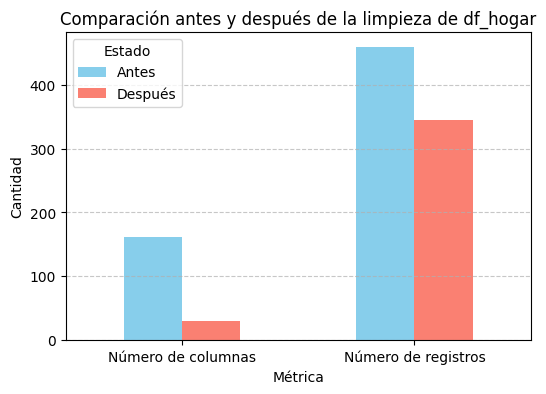

In [ ]:
# Obtener valores originales de df_ninos desde summary_df
original_cols = summary_df.loc[summary_df["DF"] == "df_ninos", "Número de Columnas"].values[0]
original_rows = summary_df.loc[summary_df["DF"] == "df_ninos", "Número de registros"].values[0]

# Crear DataFrame de comparación
comparison_df = pd.DataFrame({
    "Métrica": ["Número de columnas", "Número de registros"],
    "Antes": [original_cols, original_rows],
    "Después": [df_ninos.shape[1], df_ninos.shape[0]]
})

# Mostrar la tabla
display(comparison_df)

# Graficar la comparación
fig, ax = plt.subplots(figsize=(6, 4))
comparison_df.set_index("Métrica").plot(kind="bar", ax=ax, color=["skyblue", "salmon"])
plt.title("Comparación antes y después de la limpieza de df_hogar")
plt.ylabel("Cantidad")
plt.xticks(rotation=0)
plt.legend(title="Estado")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Mostrar el gráfico
plt.show()

> #### Dataframe unificado DF_SMART

Se realizará la unión del df_hogar con el df_ninos; y este será el daset que se usará para el análisis y desarrollo del modelo

In [ ]:
# Unir df_ninos con df_hogar usando 'id_hogar' como llave
df_smart = pd.merge(df_ninos, df_hogar, on='id_hogar', how='left')

# Clonamos el df para mantener el df_smart como el original
df_smart_org = df_smart.copy()

In [ ]:
# Mostrar el DataFrame df_ninos con los datos agregados de df_hogar
display(df_smart)

,edad_anio,sexo,fecha_nacimiento,edad_meses,peso,altura,perimetro_braquial,enema,muac,referido_dag,...,indicador_rcsi,wash_acceso_agua,wash_tratamiento,wash_acceso_higiene,wash_practicas_higiene,estado_encuesta,index_hogar_y,LCSI,indicador_mddw,pb_plw
0,1,Hombre,2021-12-29,21.0,10.3,80.3,149.0,No,41.7,NaN,...,13.0,Acueducto,Sí,Sí,Sí,Encuestado 100%,2,Estrategias de Crisis,3.0,417.0
1,4,Mujer,2019-02-15,55.0,14.1,99.1,160.0,No,NaN,NaN,...,16.0,Fuente de agua subterránea,No,No,Sí,Encuestado 100%,3,Estrategias de Emergencia,NaN,NaN
2,3,Mujer,2020-07-15,38.0,12.8,88.6,162.0,No,NaN,NaN,...,16.0,Fuente de agua subterránea,No,No,Sí,Encuestado 100%,3,Estrategias de Emergencia,NaN,NaN
3,4,Mujer,2018-12-13,57.0,14.2,101.0,154.0,No,NaN,NaN,...,12.0,Acueducto,No,Sí,Sí,Encuestado 100%,4,Estrategias de Crisis,NaN,NaN
4,4,Hombre,2019-04-30,53.0,14.1,96.1,158.0,No,NaN,NaN,...,12.0,Acueducto,No,Sí,Sí,Encuestado 100%,4,Estrategias de Crisis,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,4,Hombre,2019-09-10,49.0,19.5,110.2,167.0,No,NaN,NaN,...,21.0,Acueducto,No,No,Sí,Encuestado 100%,1128,Estrategias de Emergencia,NaN,NaN
340,2,Mujer,2021-02-13,32.0,12.8,88.7,153.0,No,NaN,NaN,...,21.0,Acueducto,No,No,Sí,Encuestado 100%,1128,Estrategias de Emergencia,NaN,NaN
341,3,Hombre,2020-05-23,41.0,13.3,98.0,145.0,No,31.2,NaN,...,28.0,Acueducto,No,No,Sí,Encuestado 100%,1129,Estrategias de Emergencia,3.0,312.0
342,0,Mujer,2023-03-08,7.0,8.7,68.9,149.0,No,31.2,NaN,...,28.0,Acueducto,No,No,Sí,Encuestado 100%,1129,Estrategias de Emergencia,3.0,312.0


In [ ]:
# Eliminar columnas inecesarias
df_smart.drop(columns=['index_hogar_y', 'estado_encuesta'], inplace=True)

# renombra columnas index
df_smart.rename(columns={'index_hogar_x': 'index_hogar'}, inplace=True)

In [ ]:
import pandas as pd

# 1. Obtener datos INICIALES (antes de depurar)
summary_data = []
for df_name, sheet_name in dataframes.items():
    df = all_sheets[sheet_name]  # Asume que `all_sheets` contiene los DataFrames originales
    summary_data.append([df_name, sheet_name, df.shape[1], df.shape[0]])

summary_df = pd.DataFrame(summary_data, columns=['DF', 'Descripción', 'Columnas (antes)', 'Registros (antes)'])

# 2. Datos DESPUÉS de la depuración (asumiendo que algunos DF fueron descartados)
# Diccionario con los DataFrames que SÍ se conservan (los demás tendrán 0 filas/columnas)
df_conservados = {
    'df_hogar': df_hogar,
    'df_ninos': df_ninos
}

# Agregar datos al resumen
resumen_despues = []
for df_name, sheet_name in dataframes.items():
    if df_name in df_conservados:
        df = df_conservados[df_name]
        columnas, registros = df.shape[1], df.shape[0]
    else:
        columnas, registros = 0, 0  # DataFrames descartados

    resumen_despues.append([df_name, columnas, registros])

# Convertir a DataFrame
df_despues = pd.DataFrame(resumen_despues, columns=['DF', 'Columnas (después)', 'Registros (después)'])

# 3. Combinar ambos resúmenes (ANTES vs. DESPUÉS)
df_comparativo = pd.merge(
    summary_df,
    df_despues,
    on='DF'
)

# 4. Mostrar tabla comparativa
print("Comparación: Antes vs. Después de la Depuración")
display(df_comparativo)

# 5. (Opcional) Resaltar cambios con estilo
def resaltar_cambios(val):
    if val == 0:
        return 'color: red; font-weight: bold'
    return ''

styled_df = df_comparativo.style.applymap(
    resaltar_cambios,
    subset=['Columnas (después)', 'Registros (después)']
)
display(styled_df)

Comparación: Antes vs. Después de la Depuración


,DF,Descripción,Columnas (antes),Registros (antes),Columnas (después),Registros (después)
0,df_hogar,SMART HOGAR,35,1147,20,886
1,df_fallecimientos,FALLECIMIENTOS,15,6,0,0
2,df_plw,GEST-LACT,10,125,0,0
3,df_miembros,MIEMBROS,23,3514,0,0
4,df_ninos,NIÑOS,51,459,30,344
5,df_no_miembros,NO MIEMBROS,13,94,0,0


<ipython-input-374-2b3561c843be>:49: FutureWarning:

Styler.applymap has been deprecated. Use Styler.map instead.



,DF,Descripción,Columnas (antes),Registros (antes),Columnas (después),Registros (después)
0,df_hogar,SMART HOGAR,35,1147,20,886
1,df_fallecimientos,FALLECIMIENTOS,15,6,0,0
2,df_plw,GEST-LACT,10,125,0,0
3,df_miembros,MIEMBROS,23,3514,0,0
4,df_ninos,NIÑOS,51,459,30,344
5,df_no_miembros,NO MIEMBROS,13,94,0,0


In [ ]:
# @title Tabla de valores <font color='tomato'>nulos</font>
N = df_smart.shape[0]
nvals = df_smart.isnull().sum(axis=0)
percent = round(nvals/N*100, 2)
df_nulo = pd.DataFrame({'Valores':N-nvals, 'Nulos':nvals, 'Porcentaje': percent}).reset_index(names=['Variables'])
df_nulo.sort_values('Porcentaje', ascending=False, inplace=True)
df_nulo = df_nulo[df_nulo.Nulos>0]
df_nulo

,Variables,Valores,Nulos,Porcentaje
10,referido_dam,1,343,99.71
9,referido_dag,1,343,99.71
24,lactancia_exclusiva,21,323,93.90
14,Nn_114,80,264,76.74
26,Cumple_MDD,99,245,71.22
27,MMF,99,245,71.22
28,MMFF,99,245,71.22
29,DMA,99,245,71.22
25,MDD,99,245,71.22
46,pb_plw,111,233,67.73


In [ ]:
# @title Gráfica de los valores nulos por variable
import plotly.express as px

# Lista de colores personalizada
colores = ['lightseagreen']

# Crear la gráfica usando la secuencia de colores personalizada
fig = px.bar(
    df_nulo,
    x='Variables',
    y='Nulos',
    color='Variables',  # clave para que cada barra tenga un color distinto
    color_discrete_sequence=colores,
    width=960,
    text_auto=True,
    title='Cantidad de valores nulos por columnas',
    hover_name='Porcentaje'
)

fig.update_layout(
    plot_bgcolor='white',
    yaxis_title_text='Conteo de nulos',
    showlegend=False  # opcional, para ocultar la leyenda si no es necesaria
)

fig.show()


In [ ]:
#Valores únicos de las columnas "referidos_dam", "referido_dag" y "lactancia_exclusiva"
print("Referido DAM:", df_smart['referido_dam'].unique())
print("Referidos DAG:",df_smart['referido_dag'].unique())
print("Lactancia exclusiva:", df_smart['lactancia_exclusiva'].unique())

Referido DAM: [nan 'Sí']
Referidos DAG: [nan 'Sí']
Lactancia exclusiva: [nan  1.  0.]


<font color='steelblue' size=5>
Análisis <br>

</font>

---
> De acuerdo con los resultados obtenidos, las variables que indican la identificación de signos de desnutrición aguda `referido_dag` y moderada `referido_dam`  por parte del profesional de la salud presentan solo un registro. Dado su escaso número de datos, no aportan información significativa para el análisis.  

> Por otro lado, la variable `lactancia_exclusiva` es relevante en el estudio del estado nutricional de niños y niñas menores de seis meses, considerando que la OMS enfatiza la importancia de la lactancia exclusiva durante este período. Sin embargo, en este conjunto de datos, todos los registros presentan un valor de cero para esta variable, lo que impide su utilidad en el análisis.  

En consecuencia, se ha decidido excluir estas tres variables del *dataframe*.

In [ ]:
#Se eliminan las variables referido_dam', 'referido_dag', 'lactancia_exclusiva'
df_smart = df_smart.drop(['referido_dam', 'referido_dag', 'lactancia_exclusiva'], axis=1)

In [ ]:
# @title Clasifiación por rango etarios

# Definir condiciones y etiquetas
condiciones = [
    (df_smart['edad_meses'] < 6),
    (df_smart['edad_meses'] >= 6) & (df_smart['edad_meses'] <= 23),
    (df_smart['edad_meses'] > 23) & (df_smart['edad_meses'] <= 59)
]

etiquetas = ['nn_0_6m', 'nn_6_23m', 'nn_23_59m']

# Crear la nueva columna
df_smart['rango_etario'] = np.select(condiciones, etiquetas, default='fuera_rango')

In [ ]:
import pandas as pd

# Función para contar NA y total en formato "NA/Total"
def contar_na_y_total(serie):
    na = serie.isna().sum()
    total = len(serie)
    return f"{na}/{total}"

# Aplicar por grupo y transponer
resultado = df_smart.groupby('rango_etario').apply(lambda x: x.apply(contar_na_y_total)).T

# Agregar columna con el tipo de dato
resultado["Tipo de dato"] = df_smart.dtypes.astype(str)

# Reordenar columnas (opcional: poner "Tipo de dato" al principio)
column_order = ["Tipo de dato"] + [col for col in resultado.columns if col != "Tipo de dato"]
resultado = resultado[column_order]

# Función para resaltar celdas con NA > 0
def resaltar_na(val):
    if isinstance(val, str) and '/' in val:  # Solo aplica a celdas con formato "NA/Total"
        na, total = map(int, val.split('/'))
        color = 'lightcoral' if na > 0 else 'lightgreen'
        return f'background-color: {color}'
    return ''

# Aplicar estilo
resultado_estilizado = resultado.style.applymap(resaltar_na)

# Mostrar resultado
resultado_estilizado

<ipython-input-380-4ca38b354fb6>:10: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-380-4ca38b354fb6>:28: FutureWarning:

Styler.applymap has been deprecated. Use Styler.map instead.



rango_etario,Tipo de dato,nn_0_6m,nn_23_59m,nn_6_23m
edad_anio,int64,0/21,0/224,0/99
sexo,object,0/21,0/224,0/99
fecha_nacimiento,object,0/21,0/224,0/99
edad_meses,float64,0/21,0/224,0/99
peso,float64,0/21,0/224,0/99
altura,float64,0/21,0/224,0/99
perimetro_braquial,float64,21/21,3/224,1/99
enema,object,1/21,0/224,1/99
muac,float64,1/21,181/224,50/99
diarrea_2semanas,object,0/21,0/224,0/99


#### Análisis general sobre variables del conjunto de datos

A continuación se presenta una revisión de cada una de las variables para seleccionar cuales serán incluidas en los respectivos análisis univariados, bivariados y de correlación.

> __Variables numéricas__

* ❌ edad_anio: Representa la edad de los niños en años, no es necesaria para el análisis [Excluir]
* ❌ fecha_nacimiento: Fue útilil para hacer el cálculo de edad en meses, no es necesaria para el análisis [Excluir]
* ✅ edad_meses: Necesario para el análisis y es un dato facial de obtener [Incluir: todos los rangos]
* ❌ peso: Dato antropromético que es exluido a proposito por el objetivo del proyecto, dato de alto costo para recolectar [Excluir]
* ❌ altura:  Dato antropromético que es exluido a proposito por el objetivo del proyecto, dato de alto costo para recolectar [Excluir]
* ✅ perimetro_braquial: Tiene nulos todos los datos para los niños en el rango de edad de 0 a 6 meses, esto solo representa el 6% del total, es una medida antropométrica de bajo costo [Incluir: rango 0 a 59]
* ❌ muac: solo está disponible el 33% de los datos puede afectar el análisis [excluir]
* ❌ index_nino: Identifcador del niño [Excluir]
* ❌ index_hogar: Identifcador del hogar [Excluir]
* ❌ id_hogar: Identifcador del hogar [Excluir]
* ❌ WHZ: Puntaje de nutrición variable objetivo [Excluir]
* ❌ lactancia_adecuada: Suma de las variables categóricas sobre practicas de lactancia [Excluir]
* ✅ MDD: Diversidad de dieta de niños entre 6 y 23 meses, incluir inicialmente, no obstante revisar correlación con el indicador HDDS que corresponde a la diega del hogar que puede llegar a ser similar [Incluir solo para el rango 0-23]
* ❌ MMF: Indicador que hace parte del cálculo del MDD [Excluir]
* ❌ MMFF: Indicador que hace parte del cálculo del MDD [Excluir]
* ❌ DMA: Indicador que hace parte del cálculo del MDD [Excluir]
* ✅ numero_familia: Indica el número de mimbros de la familia a la que pertece el niño [Incluir: todos los rangos]
* ✅ numero_ninos: Indica si en un hogar exisiten más niños de edades similares [incluir: todos los rangos]
* ✅ numero_mujeres: Indica cuantes mujeres lactantes o gestante hay en el hogar al que pertenece el niñ0 [Incluir: todos los rangos]
* ❌ numero_no_miembros: Indica cuantas personas ya no hacen parte del hogar, no es necesario para el análisis [Excluir]
* ✅ mumero_fallecidos: Indica el número de personas del hogar que han fallecido rencientente en el hogar [Incluir: todos los rangos]
* ✅ indicador_hdds: Diversidad de dieta del hogar, clave en la nutrición de los niños del hogar [Incluir: relevante para rango > 6 meses]
* ✅ indicador_rcsi: Indicador de estrategias de afrontamiento reducido, relacionado con la estabiliad del hogar [Incluir: todos los rangos]
* ✅ indicador_mddw: Diversidad de dieta de las mujeres lactacte y gestantes del hogar, revisar correlación con HDDS [Incluir: todos los rangos]
* ❌ pb_plw: Perímetro baquial de las mujeres lactantes y gestantes del hogar, baja disponibilidad de datos [Excluir]

> __Variables categóricas y discretas__

* ✅ sexo: Puede resultar determinante en el estado nutricional de los niños [Incluir]
* ❌ enema: Tiene alta disponibilidad de datos, no obstante solo presenta una categoría lo que no es útil para el análisis [Excluir]
* ✅ diarrea_2semanas: Indica si el niño se ha enfermado de diarrea en las últumas 2 semanas, esta enfermedades puedne influir en la nutrición de los niños [Incluir]
* ✅ fiebre_2semanas:Indica si el niño se ha enfermado de fiebre en las últumas 2 semanas, esta enfermedades puedne influir en la nutrición de los niños [Incluir]
* ✅ ira_2semanas: Indica si el niño se ha enfermado de infecciones respiratorias agudas en las últumas 2 semanas, esta enfermedades puedne influir en la nutrición de los niños [Incluir]
* ✅ estado_nutricional: Variable objetivo [Incluir]
* ✅ lactancia_temprana: Práctica de lactar al bebé en las primeras horas de vida 1: si , 0: no [Incluir]
* ✅ lactancia_actual: Práctica lactar actualmente al bebé en las primeras horas de vida 1: si , 0: no [Incluir]
* ✅ lactancia_duracion: Practica de lactar por más de 10 minutos consecutivos 1: si, 0: no [Incluir]
* ❌ Cumple_MDD: Se incluye el indice de MDD [Excluir]
* ✅ sector: Define si es un niño que vive en cabeceras municipale o centros poblados [Incluir]
* ❌ municipio: Municipio donde se levantaron los datos, no se hara análisis por territio [Excluir]
* ❌ zona: Barrios y veredas donde se aplicaron las encuestas, no se hará análisis por territorio [Excluir]
* ✅ wash_acceso_agua: Si o No los hogares tienen acceso agua potable [Incluir]
* ✅ wash_tratamiento: Si o No los hogares realizan tratamiento de agua [Incluir]
* ✅ wash_acceso_higiene: Si o No los hogares tiene acceso a elementos de higiene [Incluir]
* ✅ wash_practicas_higiene: Si o No los hogares implementan prácticas de higiene [Incluir]
* ✅ LCSI: Livelihood Coping Strategy Index [Incluir]

In [ ]:
import plotly.express as px

# Paleta de colores personalizada
colores = ['tomato', 'lightseagreen', 'gold', 'salmon']

# Contar la cantidad de niños en cada rango etario
df_rango = df_smart['rango_etario'].value_counts().reset_index()
df_rango.columns = ['rango_etario', 'cantidad']

# Crear el gráfico de barras con la paleta personalizada
fig = px.bar(
    df_rango,
    x='rango_etario',
    y='cantidad',
    text='cantidad',
    color='rango_etario',  # Necesario para aplicar múltiples colores
    color_discrete_sequence=colores,
    title='Distribución de Rango Etario',
    labels={'rango_etario': 'Rango Etario', 'cantidad': 'Cantidad de Niños'}
)

# Mejorar la visualización
fig.update_traces(textposition='outside')
fig.update_layout(xaxis_title='Rango Etario', yaxis_title='Cantidad', plot_bgcolor='white', showlegend=False)

# Mostrar el gráfico
fig.show()

In [ ]:
# Crear la tabla de frecuencias
tabla_estado_nutricional = df_smart['estado_nutricional'].value_counts().reset_index()
tabla_estado_nutricional.columns = ['Estado Nutricional', 'Cantidad']

# Mostrar la tabla
display(tabla_estado_nutricional)

# Contar la cantidad de casos en cada estado nutricional
df_estado = df_smart['estado_nutricional'].value_counts().reset_index()
df_estado.columns = ['estado_nutricional', 'cantidad']

# Definir el orden deseado de las categorías
orden_categorias = ['Obesidad', 'Sobrepeso', 'Riesgo de sobrepeso', 'Peso adecuado para la talla', 'Riesgo de desnutrición aguda', 'Desnutrición aguda moderada', 'Desnutrición aguda severa']

# Asegurar que el DataFrame tenga solo las categorías definidas (opcional)
df_estado = df_estado[df_estado['estado_nutricional'].isin(orden_categorias)]

# Definir colores personalizados
colores_estado = {
    'Obesidad': 'darkred',
    'Sobrepeso': 'red',
    'Riesgo de sobrepeso': 'tomato',
    'Peso adecuado para la talla': 'lightseagreen',
    'Riesgo de desnutrición aguda': 'gold',
    'Desnutrición aguda moderada': 'salmon',
    'Desnutrición aguda severa': 'firebrick',
    'Desconocido': 'lightgray'
}

# Crear el gráfico de barras con orden y colores personalizados
fig = px.bar(
    df_estado,
    x='estado_nutricional',
    y='cantidad',
    text='cantidad',
    category_orders={"estado_nutricional": orden_categorias},  # Ordenar categorías
    color='estado_nutricional',
    title='Distribución de Casos por Estado Nutricional (df_smart)',
    labels={'estado_nutricional': 'Estado Nutricional', 'cantidad': 'Cantidad de Casos'},
    color_discrete_map=colores_estado
)

# Mejorar la visualización
fig.update_traces(textposition='outside')
fig.update_layout(
    xaxis_title='Estado Nutricional',
    yaxis_title='Cantidad de Casos',
    plot_bgcolor='white',
    xaxis={'categoryorder': 'array', 'categoryarray': orden_categorias}  # Forzar orden
)

# Mostrar el gráfico
fig.show()

,Estado Nutricional,Cantidad
0,Peso adecuado para la talla,254
1,Riesgo de sobrepeso,38
2,Riesgo de desnutrición aguda,38
3,Sobrepeso,6
4,Desnutrición aguda moderada,4
5,Obesidad,4


In [ ]:
import plotly.express as px

# Definir colores y orden de categorías actualizado
colores_estado = {
    'Obesidad': 'darkred',
    'Sobrepeso': 'red',
    'Riesgo de sobrepeso': 'tomato',
    'Peso adecuado para la talla': 'lightseagreen',
    'Riesgo de desnutrición aguda': 'gold',
    'Desnutrición aguda moderada': 'salmon',
    'Desnutrición aguda severa': 'firebrick',
    'Desconocido': 'lightgray'
}

orden_categorias = [
    'Desnutrición aguda severa',
    'Desnutrición aguda moderada',
    'Riesgo de desnutrición aguda',
    'Peso adecuado para la talla',
    'Riesgo de sobrepeso',
    'Sobrepeso',
    'Obesidad'
]

# Crear el gráfico de dispersión actualizado
fig = px.scatter(
    df_smart,
    x='edad_meses',
    y='WHZ',
    color='estado_nutricional',
    title='Relación entre Edad y WHZ (Weight-for-Height Z-score)',
    labels={
        'edad_meses': 'Edad (meses)',
        'WHZ': 'WHZ (Weight-for-Height Z-score)',
        'estado_nutricional': 'Estado Nutricional'
    },
    category_orders={'estado_nutricional': orden_categorias},
    color_discrete_map=colores_estado,
    hover_data=['peso', 'altura', 'sexo'],
    template='plotly_white'
)

# Añadir líneas de referencia actualizadas
fig.add_hline(y=-3, line_dash="dot", line_color="firebrick",
              annotation_text="Desnutrición severa (WHZ < -3)",
              annotation_position="bottom right")

fig.add_hline(y=-2, line_dash="dot", line_color="salmon",
              annotation_text="Desnutrición moderada (WHZ < -2)",
              annotation_position="bottom right")

fig.add_hline(y=-1, line_dash="dot", line_color="gold",
              annotation_text="Riesgo desnutrición (WHZ < -1)",
              annotation_position="bottom right")

fig.add_hline(y=1, line_dash="dot", line_color="tomato",
              annotation_text="Riesgo sobrepeso (WHZ > +1)",
              annotation_position="top right")

fig.add_hline(y=2, line_dash="dot", line_color="red",
              annotation_text="Sobrepeso (WHZ > +2)",
              annotation_position="top right")

fig.add_hline(y=3, line_dash="dot", line_color="darkred",
              annotation_text="Obesidad (WHZ > +3)",
              annotation_position="top right")

# Personalizar el diseño
fig.update_layout(
    plot_bgcolor='white',
    xaxis_title='Edad (meses)',
    yaxis_title='WHZ (Weight-for-Height Z-score)',
    legend_title='Estado Nutricional',
    xaxis_range=[0, 60],
    yaxis_range=[-4, 4],
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

# Mostrar el gráfico
fig.show()

In [ ]:
def clasificar_whz(whz):
    """
    Clasifica el estado nutricional según los puntos de corte WHZ (Weight-for-Height Z-score)
    Basado en la tabla de referencia proporcionada.

    Parámetros:
    whz (float): Valor del Z-score peso/talla

    Retorna:
    str: Clasificación antropométrica
    """
    if whz > 1:
        return "Riesgo de sobrepeso/obesidad"
    elif whz >= -1 and whz <= 1:
        return "Peso adecuado para la talla"
    elif whz < -1:
        return "Riesgo de desnutrición aguda"
    else:
        return "Desconocido"  # Para manejar valores nulos o NaN

# Aplicar la función a la columna 'WHZ'
df_smart['estado_nutricional'] = df_smart['WHZ'].apply(clasificar_whz)

In [ ]:
# Crear la tabla de frecuencias
tabla_estado_nutricional = df_smart['estado_nutricional'].value_counts().reset_index()
tabla_estado_nutricional.columns = ['Estado Nutricional', 'Cantidad']

# Mostrar la tabla
display(tabla_estado_nutricional)

# Contar la cantidad de casos en cada estado nutricional
df_estado = df_smart['estado_nutricional'].value_counts().reset_index()
df_estado.columns = ['estado_nutricional', 'cantidad']

# Definir el orden deseado de las categorías
orden_categorias = ['Riesgo de desnutrición aguda', 'Peso adecuado para la talla','Riesgo de sobrepeso/obesidad' ]

# Asegurar que el DataFrame tenga solo las categorías definidas (opcional)
df_estado = df_estado[df_estado['estado_nutricional'].isin(orden_categorias)]

# Definir colores personalizados
colores_estado = {
    'Riesgo de sobrepeso/obsidad': 'tomato',
    'Peso adecuado para la talla': 'lightseagreen',
    'Riesgo de desnutrición aguda': 'salmon',
    'Desconocido': 'lightgray'
}

# Crear el gráfico de barras con orden y colores personalizados
fig = px.bar(
    df_estado,
    x='estado_nutricional',
    y='cantidad',
    text='cantidad',
    category_orders={"estado_nutricional": orden_categorias},  # Ordenar categorías
    color='estado_nutricional',
    title='Distribución de Casos por Estado Nutricional (df_smart)',
    labels={'estado_nutricional': 'Estado Nutricional', 'cantidad': 'Cantidad de Casos'},
    color_discrete_map=colores_estado
)

# Mejorar la visualización
fig.update_traces(textposition='outside')
fig.update_layout(
    xaxis_title='Estado Nutricional',
    yaxis_title='Cantidad de Casos',
    plot_bgcolor='white',
    xaxis={'categoryorder': 'array', 'categoryarray': orden_categorias}  # Forzar orden
)

# Mostrar el gráfico
fig.show()

,Estado Nutricional,Cantidad
0,Peso adecuado para la talla,254
1,Riesgo de sobrepeso/obesidad,48
2,Riesgo de desnutrición aguda,42


In [ ]:
import plotly.express as px

# Definir colores y orden de categorías actualizado
colores_estado = {
    'Obesidad': 'darkred',
    'Sobrepeso': 'red',
    'Riesgo de sobrepeso': 'tomato',
    'Peso adecuado para la talla': 'lightseagreen',
    'Riesgo de desnutrición aguda': 'gold',
    'Desnutrición aguda moderada': 'salmon',
    'Desnutrición aguda severa': 'firebrick',
    'Desconocido': 'lightgray'
}

orden_categorias = [
    'Desnutrición aguda severa',
    'Desnutrición aguda moderada',
    'Riesgo de desnutrición aguda',
    'Peso adecuado para la talla',
    'Riesgo de sobrepeso',
    'Sobrepeso',
    'Obesidad'
]

# Crear el gráfico de dispersión actualizado
fig = px.scatter(
    df_smart,
    x='edad_meses',
    y='WHZ',
    color='estado_nutricional',
    title='Relación entre Edad y WHZ (Weight-for-Height Z-score)',
    labels={
        'edad_meses': 'Edad (meses)',
        'WHZ': 'WHZ (Weight-for-Height Z-score)',
        'estado_nutricional': 'Estado Nutricional'
    },
    category_orders={'estado_nutricional': orden_categorias},
    color_discrete_map=colores_estado,
    hover_data=['peso', 'altura', 'sexo'],
    template='plotly_white'
)

# Añadir líneas de referencia actualizadas
fig.add_hline(y=-3, line_dash="dot", line_color="firebrick",
              annotation_text="Desnutrición severa (WHZ < -3)",
              annotation_position="bottom right")

fig.add_hline(y=-2, line_dash="dot", line_color="salmon",
              annotation_text="Desnutrición moderada (WHZ < -2)",
              annotation_position="bottom right")

fig.add_hline(y=-1, line_dash="dot", line_color="gold",
              annotation_text="Riesgo desnutrición (WHZ < -1)",
              annotation_position="bottom right")

fig.add_hline(y=1, line_dash="dot", line_color="tomato",
              annotation_text="Riesgo sobrepeso (WHZ > +1)",
              annotation_position="top right")

fig.add_hline(y=2, line_dash="dot", line_color="red",
              annotation_text="Sobrepeso (WHZ > +2)",
              annotation_position="top right")

fig.add_hline(y=3, line_dash="dot", line_color="darkred",
              annotation_text="Obesidad (WHZ > +3)",
              annotation_position="top right")

# Personalizar el diseño
fig.update_layout(
    plot_bgcolor='white',
    xaxis_title='Edad (meses)',
    yaxis_title='WHZ (Weight-for-Height Z-score)',
    legend_title='Estado Nutricional',
    xaxis_range=[0, 60],
    yaxis_range=[-4, 4],
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

# Mostrar el gráfico
fig.show()

Análisis general.

> - Primero, se hace la distinción de acuerdo con el tipo de variable
    - Variables numéricas: `numCols`
    - Variables categóricas: `catCols`
- Segundo, la variable binaria `estado_nutricional` es una varaible objetivo. Por tanto los análisis discriminan las categorías nutricionales de los niños menores de 5 años: `Desnutrición aguda severa (DAS)`, `Desnutrición Aguda moderada (DAM)`, `Normal`, `Riesgo de sobrepeso` y `Sobrepeso`

Según la base de datos y los indicadores relevantes para evaluar el estado nutricional de niños menores de 5 años, se identifican tres segmentos de edad:  

1. **Niños de 0 a 6 meses:** La variable clave en este grupo es `lactancia_exclusiva`, ya que la OMS enfatiza que una adecuada nutrición en esta etapa depende exclusivamente de la lactancia materna.  
2. **Niños de 6 a 23 meses:** En este rango, la OMS recomienda complementar la lactancia materna con una alimentación balanceada y diversificada, incorporando diferentes grupos de alimentos.  
3. **Niños de 23 a 59 meses:** En este grupo, las variables consideradas relevantes son comunes a las de los rangos anteriores, ya que la alimentación debe seguir siendo equilibrada y adecuada a las necesidades nutricionales de los niños.  

Dado este contexto y la disponibilidad de los datos, se optará por agrupar los datos en dos grupos de acuerdo con la disponibilidad de datos:  
- **Grupo 1:** Variables comunes para todos lo niños de 0 a 59 meses
- **Grupo 2:** Variables comunes para niños lactantes de 0 a 23 meses

## __Análisis de variables y modelos grupo 1__

In [ ]:
# Grupo 1. DF: Niños y niña menores de 0 a 59 meses de edad
df_smart_0_59 = df_smart.copy()

> __Variables numéricas seleccionadas para el grupo 1 correspondiente a niños y niñas menores de 0 a 59 meses__

* ✅ edad_meses: Necesario para el análisis y es un dato facial de obtener [Incluir: todos los rangos]
* ✅ perimetro_braquial: Tiene nulos todos los datos para los niños en el rango de edad de 0 a 6 meses, esto solo representa el 6% del total, es una medida antropométrica de bajo costo [Incluir: rango 0 a 59]
* ✅ numero_familia: Indica el número de mimbros de la familia a la que pertece el niño [Incluir: todos los rangos]
* ✅ numero_ninos: Indica si en un hogar exisiten más niños de edades similares [incluir: todos los rangos]
* ✅ numero_mujeres: Indica cuantes mujeres lactantes o gestante hay en el hogar al que pertenece el niñ0 [Incluir: todos los rangos]
* ✅ mumero_fallecidos: Indica el número de personas del hogar que han fallecido rencientente en el hogar [Incluir: todos los rangos]
* ✅ indicador_hdds: Diversidad de dieta del hogar, clave en la nutrición de los niños del hogar [Incluir: relevante para rango > 6 meses]
* ✅ indicador_rcsi: Indicador de estrategias de afrontamiento reducido, relacionado con la estabiliad del hogar [Incluir: todos los rangos]
* ✅ indicador_mddw: Diversidad de dieta de las mujeres lactacte y gestantes del hogar, revisar correlación con HDDS [Incluir: todos los rangos]



### G1. Análisis de variables numéricas

In [ ]:
# Columnas numéricas para el grupo de 0-59 meses (numCols_0_59)
'''
Perimetro braquial: Meida del tamaño del brazo, se hace con una cita llamada MUAC
enfermedad: en numero de emfemerdades que el niños a teniendo en las últimas dos semanas (fibre, diarrea, IRA)
numero_familia: numero de miembros del hogar
indicador_hdds: diversidad de dieta de los hogares
indicador_rcsi: estrategias de afrontamiento reducido
'''
numCols_0_59 = df_smart.select_dtypes(include=np.number).columns.intersection([
    'edad_meses','perimetro_braquial', 'numero_familia', 'numero_ninos', 'numero_mujeres', 'numero_fallecido', 'indicador_hdds', 'indicador_rcsi', 'indicador_mddw'
]).difference(['index_nino', 'index_hogar', 'id_hogar']).tolist()

In [ ]:
# Descripción de variables numéricas para niños y niñas de 0 a 5 años
df_smart_0_59[numCols_0_59].describe().T

,count,mean,std,min,25%,50%,75%,max
edad_meses,344.0,32.142442,17.251697,0.0,18.0,32.5,47.0,59.0
indicador_hdds,344.0,7.345930,2.010058,2.0,6.0,7.0,9.0,12.0
indicador_mddw,128.0,4.125000,2.285697,0.0,2.5,4.0,5.0,10.0
indicador_rcsi,344.0,24.360465,16.741849,0.0,9.0,24.0,39.0,56.0
numero_familia,344.0,5.363372,2.233836,2.0,4.0,5.0,6.0,14.0
numero_mujeres,344.0,0.375000,0.496709,0.0,0.0,0.0,1.0,2.0
numero_ninos,344.0,1.558140,0.772783,1.0,1.0,1.0,2.0,5.0
perimetro_braquial,319.0,155.576803,14.276015,125.0,145.0,155.0,164.0,213.0


In [ ]:
# Histogramas ajustados por variable numérica y visualización de valores atípicos
def hist_var(df, var, init, fin):
    fig = px.histogram(df, x=var, title=var, text_auto=True, nbins=12, marginal='rug', color_discrete_sequence=['sandybrown'])
    fig.update_layout(bargap=0.2, width=960, plot_bgcolor='white', height=350)
    fig.update_yaxes(visible=False)
    fig.show()
    df1 = df[(df[var]>init) & (df[var]<fin)]
    fig = px.histogram(df1, x=var, text_auto=True, nbins=12, marginal='box', color_discrete_sequence=['tan'])
    fig.update_layout(bargap=0.2, width=960, plot_bgcolor='white', height=350)
    fig.update_yaxes(visible=False)
    fig.show()

In [ ]:
# Histogramas para el Índice de Diversidad Dietética en los Hogares (HDDS)
# es una medida de la variedad de alimentos que consume un hogar
hist_var(df_smart_0_59, 'numero_familia', 0, 300)

In [ ]:
# Histogramas para el perimetro baquial de niños y niñas
#es la medición del perímero del brazo con cinta muac
hist_var(df_smart_0_59, 'perimetro_braquial', 0, 300)

In [ ]:
# @title Depuración valores atipicos
'''
# Eliminar los datos a tipicos de la columna numero_familia <10 cuando estado nutricional es "normal"
df_smart_0_59 = df_smart_0_59[~((df_smart_0_59['estado_nutricional'] == 'Peso adecuado para la talla') & (df_smart_0_59['numero_familia'] >= 10))]

# Eliminar los datos a tipicos de la columna numero_familia <10 cuando estado nutricional es "normal"
df_smart_0_59 = df_smart_0_59[~((df_smart_0_59['estado_nutricional'] == 'Riesgo de sobrepeso/obesidad') & (df_smart_0_59['numero_familia'] >= 10))]

# Eliminar los datos a tipicos de la columna perimetro_braquia >193 y <127 cuando estado nutricional es "normal"
df_smart_0_59 = df_smart_0_59[~((df_smart_0_59['estado_nutricional'] == 'Peso adecuado para la talla') &
                                 ((df_smart_0_59['perimetro_braquial'] > 193) |
                                  (df_smart_0_59['perimetro_braquial'] < 127)))]

# Eliminar los datos a tipicos de la columna perimetro_braquia >193 y <127 cuando estado nutricional es "normal"
df_smart_0_59 = df_smart_0_59[~((df_smart_0_59['estado_nutricional'] == 'Riesgo de sobrepeso/obesidad') &
                                 (df_smart_0_59['perimetro_braquial'] >= 210))]
'''

'\n# Eliminar los datos a tipicos de la columna numero_familia <10 cuando estado nutricional es "normal"\ndf_smart_0_59 = df_smart_0_59[~((df_smart_0_59[\'estado_nutricional\'] == \'Peso adecuado para la talla\') & (df_smart_0_59[\'numero_familia\'] >= 10))]\n\n# Eliminar los datos a tipicos de la columna numero_familia <10 cuando estado nutricional es "normal"\ndf_smart_0_59 = df_smart_0_59[~((df_smart_0_59[\'estado_nutricional\'] == \'Riesgo de sobrepeso/obesidad\') & (df_smart_0_59[\'numero_familia\'] >= 10))]\n\n# Eliminar los datos a tipicos de la columna perimetro_braquia >193 y <127 cuando estado nutricional es "normal"\ndf_smart_0_59 = df_smart_0_59[~((df_smart_0_59[\'estado_nutricional\'] == \'Peso adecuado para la talla\') &\n                                 ((df_smart_0_59[\'perimetro_braquial\'] > 193) |\n                                  (df_smart_0_59[\'perimetro_braquial\'] < 127)))]\n\n# Eliminar los datos a tipicos de la columna perimetro_braquia >193 y <127 cuando est

In [ ]:
# Gráficas de distribución variables numericas para niños/niñas de 0 a 5 años
N = len(numCols_0_59)


# Filtrar datos por estado nutricional (usando df_smart_0_59)
df_rda = df_smart_0_59[df_smart_0_59['estado_nutricional'] == 'Riesgo de desnutrición aguda']
df_nor = df_smart_0_59[df_smart_0_59['estado_nutricional'] == 'Peso adecuado para la talla']
df_rsp = df_smart_0_59[df_smart_0_59['estado_nutricional'] == 'Riesgo de sobrepeso/obesidad']

for i in range(N):
    fig = make_subplots(rows=1, cols=2, subplot_titles=[numCols_0_59[i], numCols_0_59[i]], vertical_spacing=0.05)

    # Gráficos de violín (usar Y en lugar de X)
    fig.add_trace(go.Violin(y=df_rda[numCols_0_59[i]], line_color='salmon', name='Riesgo de desnutrición aguda', scalegroup='Yes'), row=1, col=1)
    fig.add_trace(go.Violin(y=df_nor[numCols_0_59[i]], line_color='lightseagreen', name='Peso adecuado para la talla', scalegroup='Yes'), row=1, col=1)
    fig.add_trace(go.Violin(y=df_rsp[numCols_0_59[i]], line_color='salmon', name='Riesgo de sobrepeso/obesidad', scalegroup='Yes'), row=1, col=1)

    # Gráfico de distribución general
    fig.add_trace(go.Violin(y=df_smart[numCols_0_59[i]], line_color='skyblue', name=numCols_0_59[i], box_visible=True), row=1, col=2)

    # Ajustes de diseño
    fig.update_layout(height=500, width=1280, plot_bgcolor='white')
    fig.update_traces(orientation='v', side='positive', meanline_visible=True)

    fig.show()

In [ ]:
# Crear lista para guardar los dataframes de resumen por variable
tablas_resumen = []

# Iterar sobre las variables numéricas
for col in numCols_0_59:
    # Agrupar por estado nutricional y calcular estadísticas
    resumen = df_smart_0_59.groupby('estado_nutricional')[col].describe().round(2)

    # Añadir una columna con el nombre de la variable para identificar en el resumen
    resumen.insert(0, 'Variable', col)

    # Reset index para convertir 'estado_nutricional' en columna
    resumen = resumen.reset_index()

    # Agregar a la lista
    tablas_resumen.append(resumen)

# Unir todas las tablas en una sola
tabla_final = pd.concat(tablas_resumen, ignore_index=True)

# Mostrar la tabla
import plotly.express as px
fig = px.scatter(
    title='Estadísticas descriptivas por variable numérica y estado nutricional'
)
display(tabla_final)

,estado_nutricional,Variable,count,mean,std,min,25%,50%,75%,max
0,Peso adecuado para la talla,edad_meses,254.0,32.80,17.22,0.0,19.00,34.5,48.00,59.0
1,Riesgo de desnutrición aguda,edad_meses,42.0,32.55,16.53,4.0,20.50,33.5,45.25,59.0
2,Riesgo de sobrepeso/obesidad,edad_meses,48.0,28.31,17.86,0.0,15.25,24.5,45.00,59.0
3,Peso adecuado para la talla,indicador_hdds,254.0,7.22,1.91,2.0,6.00,7.0,9.00,12.0
4,Riesgo de desnutrición aguda,indicador_hdds,42.0,7.67,2.42,3.0,6.00,8.0,9.00,12.0
5,Riesgo de sobrepeso/obesidad,indicador_hdds,48.0,7.71,2.11,3.0,6.00,8.0,9.00,12.0
6,Peso adecuado para la talla,indicador_mddw,94.0,3.89,2.10,0.0,2.00,3.0,5.00,10.0
7,Riesgo de desnutrición aguda,indicador_mddw,17.0,4.47,2.90,0.0,2.00,4.0,6.00,10.0
8,Riesgo de sobrepeso/obesidad,indicador_mddw,17.0,5.06,2.49,1.0,3.00,4.0,7.00,10.0
9,Peso adecuado para la talla,indicador_rcsi,254.0,25.17,16.56,0.0,11.00,25.5,42.00,56.0


> Comparativo de variables por nivel de relevancia según el análisis univariado para el grupo de 0 a 5 años

| **Variable**               | **Relevancia**                | **Justificación**                                                                 |
|----------------------------|-------------------------------|-----------------------------------------------------------------------------------|
| `edad_meses`               | Moderadamente relevante       | Sobrepeso/obesidad en niños más jóvenes.                                          |
| `indicador_hdds`           | No relevante                  | Sin diferencias significativas entre grupos.                                      |
| `indicador_mddw`           | Relevante (sobrepeso)         | Mayor diversidad dietética en sobrepeso/obesidad.                                 |
| `indicador_rcsi`           | Relevante                     | Sobrepeso asociado a menor inseguridad alimentaria.                               |
| `numero_familia`           | Moderadamente relevante       | Sobrepeso en familias más pequeñas.                                              |
| `numero_mujeres`           | No relevante                  | Diferencias mínimas.                                                              |
| `numero_ninos`             | No relevante                  | Diferencias pequeñas y no concluyentes.                                           |
| `perimetro_braquial`       | **Muy relevante**             | Indicador clave para diferenciar los tres estados nutricionales.                  |

In [ ]:
# @title Correlación de variables numéricas
from matplotlib.colors import Colormap

c = (df_smart_0_59[numCols_0_59].corr()*100).round(2)
mask = np.triu(np.ones_like(c, dtype=bool))
c = c.mask(mask)

fig = px.imshow(c, text_auto=True, width=640, color_continuous_scale='Armyrose', color_continuous_midpoint=0, title='Correlación')
fig.update_layout(xaxis={'side': 'bottom'}, plot_bgcolor='white')
fig.show()

> Análisis de variables

1. Correlaciones Fuertes (Potencial Problema de Multicolinealidad)
* indicador_mddw vs. indicador_hdds (72.03%): Ambas miden diversidad dietética, pero en contextos diferentes (hogar vs. mujeres lactantes). Se toma de decisición de excluir indicador_mddw (dieta de mujeres gestantes y lactantes) estaría contemplada en la viariable de dieta del hogar (indicador_hdds)

* numero_ninos vs. numero_familia (60.16%): El número de niños está naturalmente correlacionado con el tamaño de la familia. Se toma la decisión de excluir numero_ninos y conservar numero_familia dado que es más completa.

2. Correlaciones Moderadas
* indicador_rcsi vs. indicador_hdds (-50.12%): A mayor diversidad dietética en el hogar (hdds), menor inseguridad alimentaria en los hogares (rcsi).

* edad_meses vs. perimetro_braquial (43.87%): Los niños mayores tienden a tener un perímetro braquial más alto (crecimiento normal).No se descarta, ya que el perímetro braquial es clave para el estado nutricional.


Conclusiones del análisis

> Variables a Conservar:

* ✅ perimetro_braquial: el mejor discriminador, alta relevancia nutricional y correlaciones manejables.
* ✅ edad_meses: relación moderada con el perímetro, pero no redundante.
* ✅ indicador_rcsi: Las medias permiten diferenciar los grupos de estados nutricionales.
* ✅ numero_familia: Recoge la variable numero_ninos y contribuya a la diferenciación del estado nutricional.
* ✅ indicador_hdds: Diversidad de dieta del hogar

> Variables a Eliminar por Redundancia:

* ❌ indicador_mddw porque se usará el  indicador_hdds
* ❌ numero_ninos (se usará numero_familia)..
* ❌ numero_mujeres y numero_ninos (diferencias insignificantes).

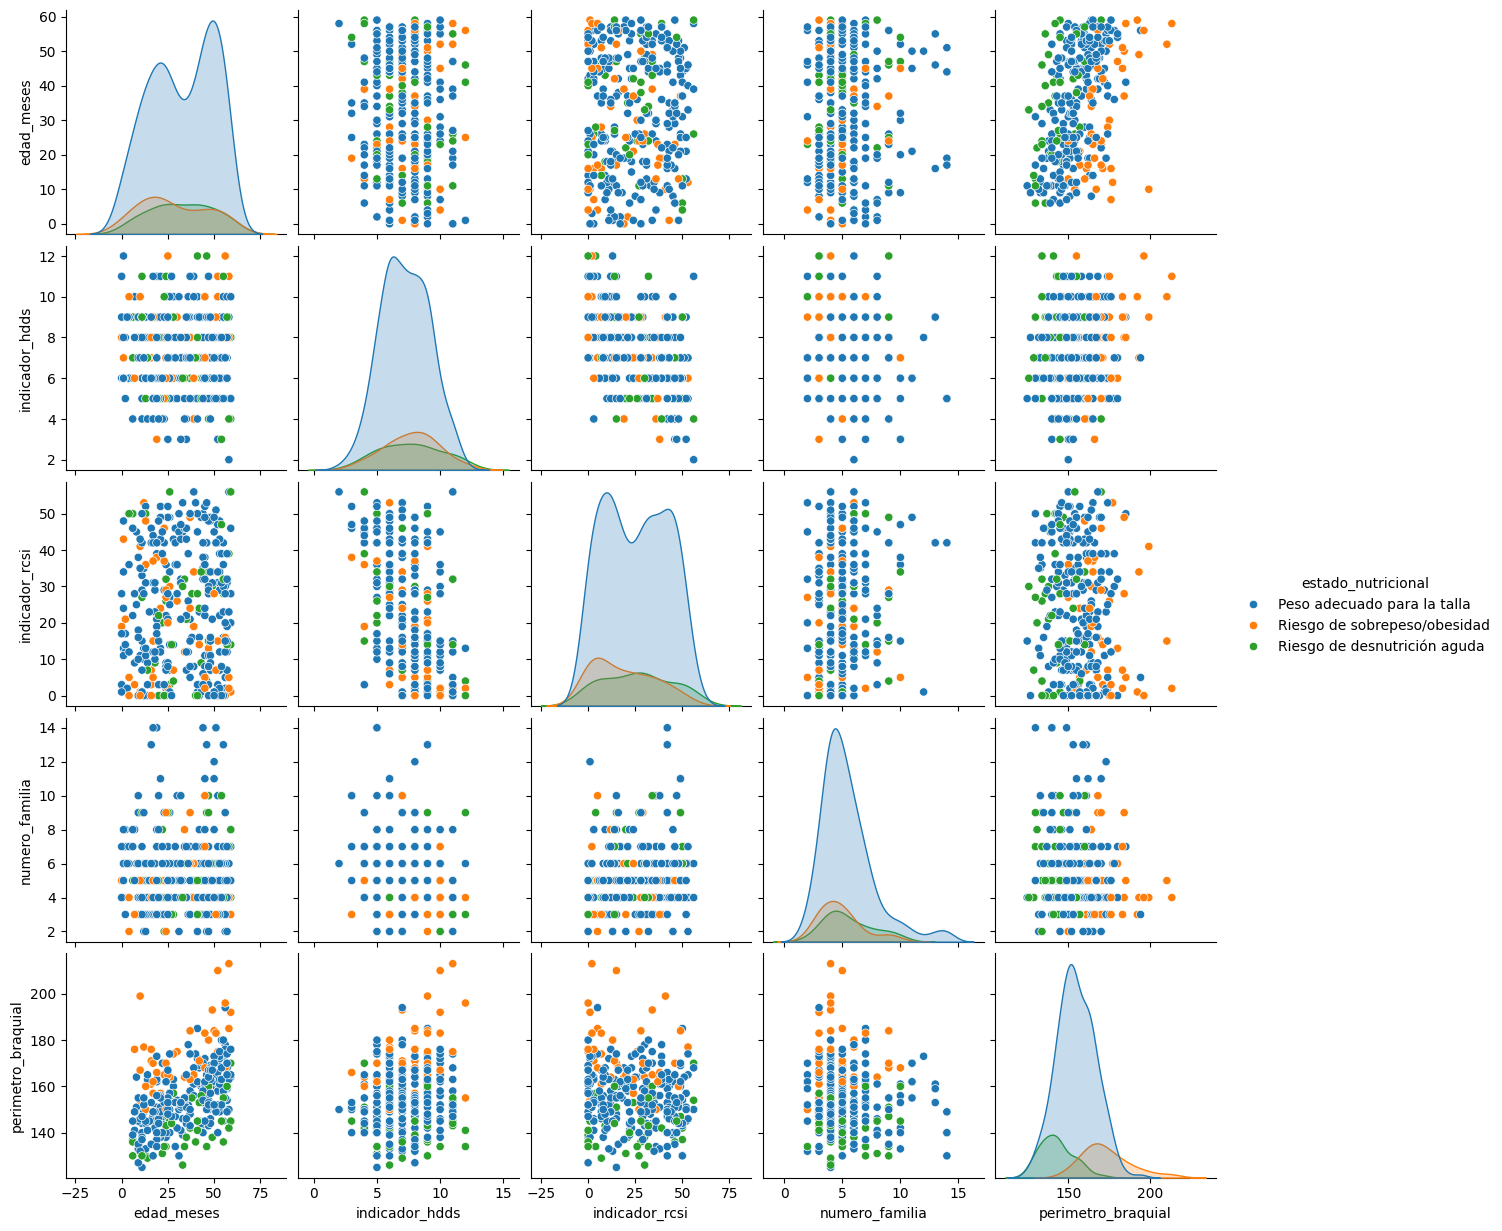

In [ ]:
# ajuste de columnas seleccionadas
numCols_0_59 = df_smart.select_dtypes(include=np.number).columns.intersection([
    'edad_meses','perimetro_braquial', 'numero_familia', 'indicador_hdds', 'indicador_rcsi'
]).difference(['index_nino', 'index_hogar', 'id_hogar']).tolist()

sns.pairplot(df_smart_0_59, hue='estado_nutricional', vars=numCols_0_59)

> Análisis

Como se puede observar las variables indicador_hdds, ambas variables aparecen como líneas verticales de puntos perfectamente alineados. Esto ocurre porque tienen un número muy limitado de valores posibles, es decir son variables discretas  codificadas como numéricas, no continuas.

Para efctos del análisi de gráfico serán excluidas estas dos variables ya que dificultan la visualización, al estar tan discretizadas, generan gráficos con líneas de puntos que no reflejan patrones o tendencias claras, adempas, no ayudan a identificar relaciones no lineales o graduales entre variables, no obstante, se considera usarlas en modelos donde se manejen variables categóricas.

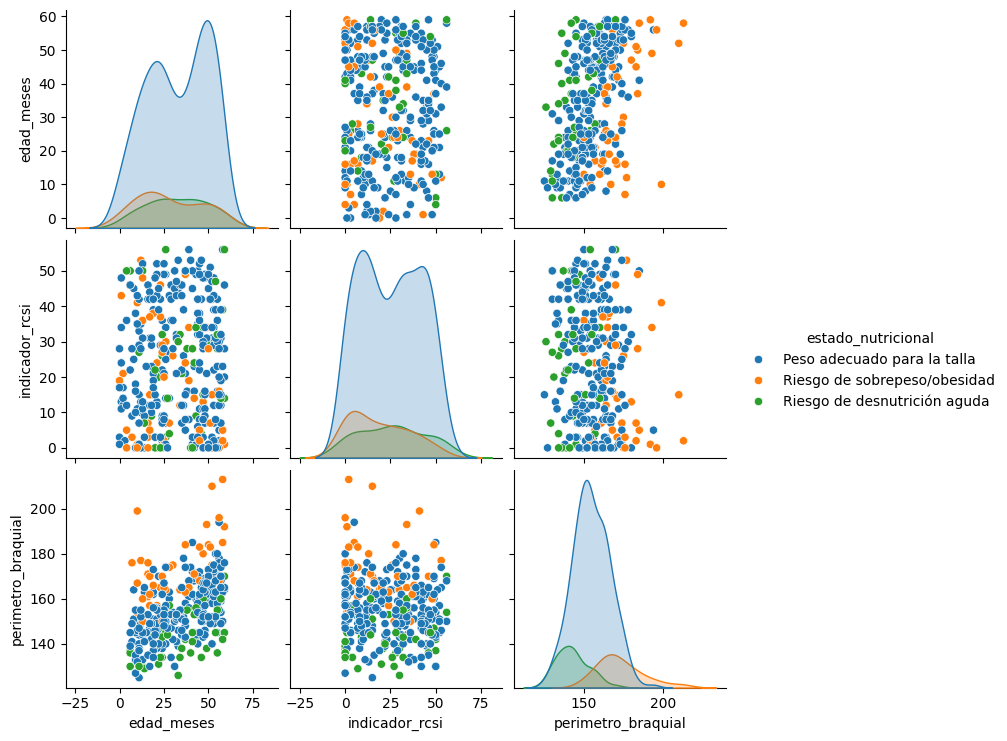

In [ ]:
# @title Análisis bivariado variables numéricas
# ajuste de columnas seleccionadas
numCols_0_59 = df_smart.select_dtypes(include=np.number).columns.intersection([
    'edad_meses','perimetro_braquial',  'indicador_rcsi'
]).difference(['index_nino', 'index_hogar', 'id_hogar']).tolist()

sns.pairplot(df_smart_0_59, hue='estado_nutricional', vars=numCols_0_59)

 🔍 1. **Distribución por variable individual (diagonales)**

* **`edad_meses`**:

  * Distribución bimodal (dos picos), lo que sugiere que hay dos grupos de edad claramente definidos.
  * La mayor parte de los niños en riesgo de desnutrición aguda o sobrepeso se concentran en los primeros 30 meses.

* **`indicador_rcsi`** (estrategia de afrontamiento):

  * La mayoría tiene valores entre 0 y 50, con mayor concentración entre 10 y 30.
  * Su distribución también sugiere datos discretos, aunque es más variable que `indicador_hdds`.

* **`perimetro_braquial`**:

  * Clara diferencia en la media entre los grupos:

    * Niños con **peso adecuado** tienen perímetros más altos.
    * Los que están en **riesgo de desnutrición aguda** tienden a tener valores más bajos.
    * En riesgo de **sobrepeso/obesidad**, hay valores notoriamente más altos (se observa una cola larga a la derecha).


🔁 2. **Relaciones bivariadas (fuera de la diagonal)**

* **`edad_meses` vs. `perimetro_braquial`**:

  * Relación positiva moderada: a mayor edad, mayor perímetro, aunque hay dispersión.
  * Niños con riesgo de sobrepeso tienden a tener perímetros elevados incluso a edades tempranas.

* **`indicador_rcsi` vs. `perimetro_braquial`**:

  * No se observa una relación clara, lo cual sugiere que el nivel de afrontamiento (rcsi) no se correlaciona fuertemente con el estado nutricional medido por perímetro.

* **`edad_meses` vs. `indicador_rcsi`**:

  * Distribución dispersa sin un patrón claro.
  * Todos los estados nutricionales están distribuidos de forma similar, indicando que el indicador\_rcsi no varía significativamente con la edad.

📌 Conclusiones:

* ✅ **`edad_meses` y `perimetro_braquial` son variables útiles** para distinguir entre estados nutricionales. Especialmente el perímetro braquial, que muestra una buena separación entre grupos.
* ⚠️ **`indicador_rcsi` muestra menor capacidad de discriminación**, pero no tan marcada como para excluirla de forma automática. Puede mantenerse en el análisis con precaución, o evaluarse su relevancia con un método como selección de características (feature selection).
* 📉 Este tipo de análisis justifica por qué se deben revisar tanto la variabilidad como la distribución antes de incluir variables en modelos de predicción.


In [ ]:
# @title Variables numéricas vs categóricas
fig = go.Figure()
fig.add_trace(go.Violin(y=df_smart_0_59['perimetro_braquial'], x=df_smart_0_59['estado_nutricional'], box_visible=True, name='Estado Nutricinal'))
fig.add_trace(go.Violin(y=df_smart_0_59['perimetro_braquial'], x=df_smart_0_59['sexo'], box_visible=True, name='Sexo'))
fig.add_trace(go.Violin(y=df_smart_0_59['perimetro_braquial'], x=df_smart_0_59['sector'], box_visible=True, name='Sector'))
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Violin(y=df_smart_0_59['indicador_rcsi'], x=df_smart_0_59['estado_nutricional'], box_visible=True, name='Estado Nutricinal'))
fig.add_trace(go.Violin(y=df_smart_0_59['indicador_rcsi'], x=df_smart_0_59['sexo'], box_visible=True, name='Sexo'))
fig.add_trace(go.Violin(y=df_smart_0_59['indicador_rcsi'], x=df_smart_0_59['sector'], box_visible=True, name='Sector'))
fig.show()

### G1. Análisis de variables discretas y categóricas

> __Variables categóricas y discretas__

* ✅ sexo: Puede resultar determinante en el estado nutricional de los niños [Incluir]
* ✅ diarrea_2semanas: Indica si el niño se ha enfermado de diarrea en las últumas 2 semanas, esta enfermedades puedne influir en la nutrición de los niños [Incluir]
* ✅ fiebre_2semanas:Indica si el niño se ha enfermado de fiebre en las últumas 2 semanas, esta enfermedades puedne influir en la nutrición de los niños [Incluir]
* ✅ ira_2semanas: Indica si el niño se ha enfermado de infecciones respiratorias agudas en las últumas 2 semanas, esta enfermedades puedne influir en la nutrición de los niños [Incluir]
* ✅ estado_nutricional: Variable objetivo [Incluir]
* ✅ sector: Define si es un niño que vive en cabeceras municipale o centros poblados [Incluir]
* ✅ wash_acceso_agua: Si o No los hogares tienen acceso agua potable [Incluir]
* ✅ wash_tratamiento: Si o No los hogares realizan tratamiento de agua [Incluir]
* ✅ wash_acceso_higiene: Si o No los hogares tiene acceso a elementos de higiene [Incluir]
* ✅ wash_practicas_higiene: Si o No los hogares implementan prácticas de higiene [Incluir]
* ✅ LCSI: Livelihood Coping Strategy Index [Incluir]

In [ ]:
# Columnas categóricas, binarias y discretas para el grupo de 0-59 meses (catCols_0_59)
catCols_0_59 = df_smart.select_dtypes(include=['object', 'category']).columns.intersection([
    'sexo', 'diarrea_2semanas', 'fiebre_2semanas', 'ira_2semanas', 'wash_tratamiento', 'wash_acceso_higiene', 'wash_practicas_higiene', 'wash_acceso_agua', 'LCSI', 'sector'
]).tolist()


In [ ]:
# Mostrar describe() en formato vertical transpuesto
df_smart_0_59[catCols_0_59].describe().T

,count,unique,top,freq
sexo,344,2,Mujer,176
diarrea_2semanas,344,2,No,283
fiebre_2semanas,344,2,No,241
ira_2semanas,344,2,No,221
sector,344,2,Cabecera Municipal,332
wash_acceso_agua,344,7,Acueducto,240
wash_tratamiento,344,2,No,247
wash_acceso_higiene,344,2,Sí,300
wash_practicas_higiene,344,2,Sí,341
LCSI,344,4,Estrategias de Emergencia,157


### G1. Análisis de distribución de variable

In [ ]:
catCols_0_59 = [
    'sexo',
    'diarrea_2semanas',
    'fiebre_2semanas',
    'ira_2semanas',
    'wash_tratamiento',
    'wash_acceso_higiene',
    'wash_practicas_higiene',
    'wash_acceso_agua',
    'LCSI',
    'sector',
    'estado_nutricional'
]

fig = make_subplots(rows=4, cols=4, subplot_titles=catCols_0_59, vertical_spacing=0.1, shared_yaxes=True)
# mostrar graficas en este orden
for i in range(len(catCols_0_59)):
    fig.add_trace(go.Histogram(x=df_smart_0_59[catCols_0_59[i]], name=catCols_0_59[i], texttemplate='%{y}'), row=i//4+1, col=i%4+1)
fig.update_layout(height=900, plot_bgcolor='white', showlegend=False)
fig.show()

* Se observa que la variable sexo está muy bien balanceada, lo que indica que se puede llegar a validar los resultados por sexo.

* Respecto a las variables de las enfermedades presentadas en las últumas semanas, en general están desbalancedadas, sin embargo puede resulta interesante validar como es este comportamiento respecto a la variable objetivo.

* El sector que mayormente fue consultado fueron cabeceras municipales, esto es clave para orientar los resultados.

* Respecto a los temas de WASH se puede ver una correlación entre quienes tienen acceso a acueductos y quienes no hacen tramiento al agua, la parecer para las otras fuentes los hogares realizan algún tipo de tramiento al agua. Respecto a las prácticas de higiene los hogares consultados en su mayoría realizan alguna práctica de higiene.

* Respecto a las estrategias de afrontamiento, se nota que en su mayoría los hogares consultados tien algún grado de vulnerabilidad, y que acuden a estrategias de emergencia, estrés y crisis.

In [ ]:
df_smart_0_59.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 45 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   edad_anio               344 non-null    int64  
 1   sexo                    344 non-null    object 
 2   fecha_nacimiento        344 non-null    object 
 3   edad_meses              344 non-null    float64
 4   peso                    344 non-null    float64
 5   altura                  344 non-null    float64
 6   perimetro_braquial      319 non-null    float64
 7   enema                   342 non-null    object 
 8   muac                    112 non-null    float64
 9   diarrea_2semanas        344 non-null    object 
 10  fiebre_2semanas         344 non-null    object 
 11  ira_2semanas            344 non-null    object 
 12  Nn_114                  80 non-null     object 
 13  index_nino              344 non-null    int64  
 14  index_hogar             344 non-null    in

In [ ]:
# @title Tabla de independencia de variables categóricas

from scipy.stats import chi2_contingency
relat = []
for i in df_smart_0_59[catCols_0_59].columns:
    arr = []
    for j in df_smart_0_59[catCols_0_59].columns:
        mat = pd.crosstab(df_smart_0_59[i], df_smart_0_59[j])
        ch, p, g, fq = chi2_contingency(mat.to_numpy())
        arr.append(p)
    relat.append(arr)
relat = np.array(relat)
dfrelat = pd.DataFrame(relat.round(2), columns=catCols_0_59, index=catCols_0_59)
dfrelat

,sexo,diarrea_2semanas,fiebre_2semanas,ira_2semanas,wash_tratamiento,wash_acceso_higiene,wash_practicas_higiene,wash_acceso_agua,LCSI,sector,estado_nutricional
sexo,0.00,0.03,0.60,0.58,0.83,1.00,0.97,0.47,0.28,1.00,0.34
diarrea_2semanas,0.03,0.00,0.00,0.00,1.00,1.00,0.96,0.00,0.10,1.00,0.42
fiebre_2semanas,0.60,0.00,0.00,0.00,0.70,0.91,0.61,0.44,0.00,0.18,0.29
ira_2semanas,0.58,0.00,0.00,0.00,0.59,0.35,0.49,0.11,0.08,0.46,0.02
wash_tratamiento,0.83,1.00,0.70,0.59,0.00,0.16,1.00,0.00,0.01,0.47,0.45
wash_acceso_higiene,1.00,1.00,0.91,0.35,0.16,0.00,1.00,0.14,0.04,0.36,0.14
wash_practicas_higiene,0.97,0.96,0.61,0.49,1.00,1.00,0.00,0.00,0.92,1.00,0.58
wash_acceso_agua,0.47,0.00,0.44,0.11,0.00,0.14,0.00,0.00,0.00,0.54,0.02
LCSI,0.28,0.10,0.00,0.08,0.01,0.04,0.92,0.00,0.00,0.08,0.08
sector,1.00,1.00,0.18,0.46,0.47,0.36,1.00,0.54,0.08,0.00,0.36


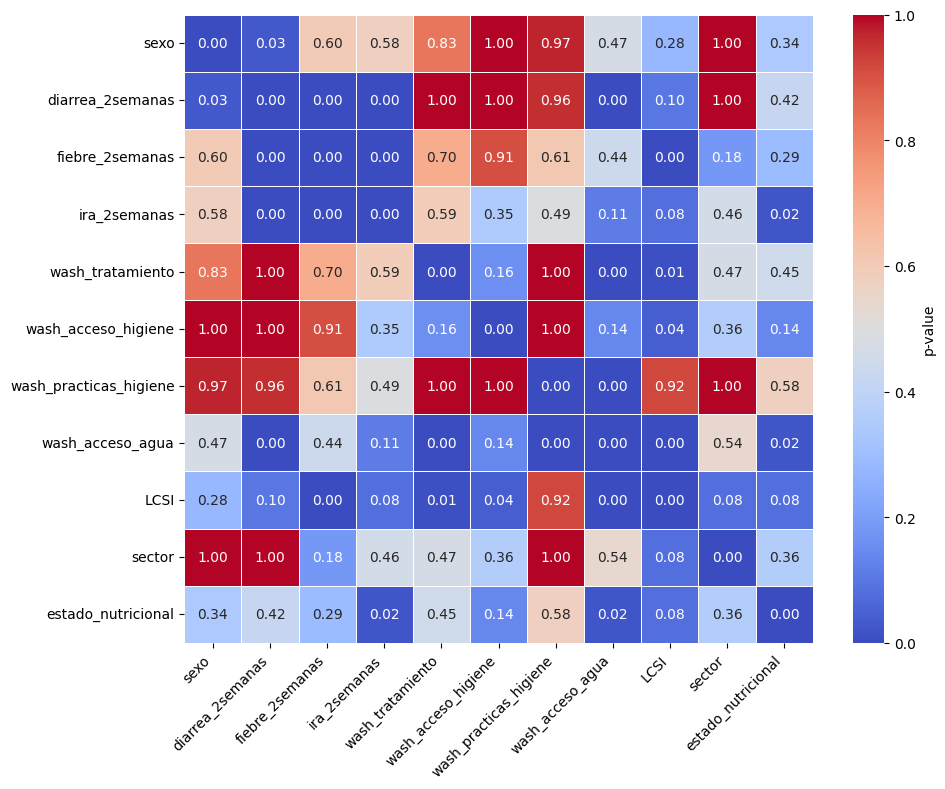

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(dfrelat, annot=True, cmap='coolwarm', vmin=0, vmax=1, linewidths=0.5, square=True,
            cbar_kws={'label': 'p-value'}, fmt='.2f')

#plt.title('Matriz de independencia entre variables categóricas (valores p)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
#copia del df_smart_0_59
df_copy = df_smart_0_59.copy()
mask = np.triu(np.ones_like(dfrelat, dtype=bool))
df_copy = dfrelat.mask(mask)
fig = px.imshow(df_copy.round(2), text_auto=True, width=960, height=800,color_continuous_scale='Armyrose', color_continuous_midpoint=0.5)
fig.update_layout(xaxis={'side': 'bottom'}, plot_bgcolor='white')
fig.show()

In [ ]:
# @title Análisis de variables categóricas
from scipy.stats import chi2_contingency
import pandas as pd

for i in df_smart_0_59[catCols_0_59]:
    for j in df_smart_0_59[catCols_0_59]:
        if i != j:
            # Crear tabla de contingencia
            cont = pd.crosstab(df_smart_0_59[i], df_smart_0_59[j])

            # Verificar que no esté vacía y que tenga al menos 2 filas y 2 columnas
            if cont.shape[0] > 1 and cont.shape[1] > 1:
                c2, p, g, m = chi2_contingency(cont.to_numpy())
                print(i, j, round(p*100, 2), sep='\t')
                if p <= 0.05:
                    display(cont)

sexo	diarrea_2semanas	2.95


diarrea_2semanas,No,Sí
sexo,,
Hombre,130,38
Mujer,153,23


sexo	fiebre_2semanas	60.48
sexo	ira_2semanas	58.44
sexo	wash_tratamiento	83.44
sexo	wash_acceso_higiene	99.7
sexo	wash_practicas_higiene	96.77
sexo	wash_acceso_agua	47.31
sexo	LCSI	27.91
sexo	sector	100.0
sexo	estado_nutricional	34.18
diarrea_2semanas	sexo	2.95


sexo,Hombre,Mujer
diarrea_2semanas,,
No,130,153
Sí,38,23


diarrea_2semanas	fiebre_2semanas	0.0


fiebre_2semanas,No,Sí
diarrea_2semanas,,
No,223,60
Sí,18,43


diarrea_2semanas	ira_2semanas	0.0


ira_2semanas,No,Sí
diarrea_2semanas,,
No,201,82
Sí,20,41


diarrea_2semanas	wash_tratamiento	100.0
diarrea_2semanas	wash_acceso_higiene	100.0
diarrea_2semanas	wash_practicas_higiene	96.13
diarrea_2semanas	wash_acceso_agua	0.01


wash_acceso_agua,Acueducto,Agua de lluvia,Agua embotellada,Carrotanque,Fuente de agua subterránea,Fuente de agua superficial,Otra
diarrea_2semanas,,,,,,,
No,208,11,11,29,16,4,4
Sí,32,1,5,21,1,0,1


diarrea_2semanas	LCSI	9.99
diarrea_2semanas	sector	100.0
diarrea_2semanas	estado_nutricional	42.16
fiebre_2semanas	sexo	60.48
fiebre_2semanas	diarrea_2semanas	0.0


diarrea_2semanas,No,Sí
fiebre_2semanas,,
No,223,18
Sí,60,43


fiebre_2semanas	ira_2semanas	0.0


ira_2semanas,No,Sí
fiebre_2semanas,,
No,197,44
Sí,24,79


fiebre_2semanas	wash_tratamiento	70.32
fiebre_2semanas	wash_acceso_higiene	90.86
fiebre_2semanas	wash_practicas_higiene	61.41
fiebre_2semanas	wash_acceso_agua	43.92
fiebre_2semanas	LCSI	0.45


LCSI,Estrategias de Crisis,Estrategias de Emergencia,Estrategias de Estrés,Ninguna
fiebre_2semanas,,,,
No,55,98,71,17
Sí,26,59,15,3


fiebre_2semanas	sector	17.93
fiebre_2semanas	estado_nutricional	29.22
ira_2semanas	sexo	58.44
ira_2semanas	diarrea_2semanas	0.0


diarrea_2semanas,No,Sí
ira_2semanas,,
No,201,20
Sí,82,41


ira_2semanas	fiebre_2semanas	0.0


fiebre_2semanas,No,Sí
ira_2semanas,,
No,197,24
Sí,44,79


ira_2semanas	wash_tratamiento	58.52
ira_2semanas	wash_acceso_higiene	35.13
ira_2semanas	wash_practicas_higiene	48.84
ira_2semanas	wash_acceso_agua	11.2
ira_2semanas	LCSI	7.64
ira_2semanas	sector	45.84
ira_2semanas	estado_nutricional	2.44


estado_nutricional,Peso adecuado para la talla,Riesgo de desnutrición aguda,Riesgo de sobrepeso/obesidad
ira_2semanas,,,
No,158,24,39
Sí,96,18,9


wash_tratamiento	sexo	83.44
wash_tratamiento	diarrea_2semanas	100.0
wash_tratamiento	fiebre_2semanas	70.32
wash_tratamiento	ira_2semanas	58.52
wash_tratamiento	wash_acceso_higiene	16.1
wash_tratamiento	wash_practicas_higiene	100.0
wash_tratamiento	wash_acceso_agua	0.01


wash_acceso_agua,Acueducto,Agua de lluvia,Agua embotellada,Carrotanque,Fuente de agua subterránea,Fuente de agua superficial,Otra
wash_tratamiento,,,,,,,
No,167,3,16,44,11,3,3
Sí,73,9,0,6,6,1,2


wash_tratamiento	LCSI	0.69


LCSI,Estrategias de Crisis,Estrategias de Emergencia,Estrategias de Estrés,Ninguna
wash_tratamiento,,,,
No,55,124,59,9
Sí,26,33,27,11


wash_tratamiento	sector	46.6
wash_tratamiento	estado_nutricional	45.42
wash_acceso_higiene	sexo	99.7
wash_acceso_higiene	diarrea_2semanas	100.0
wash_acceso_higiene	fiebre_2semanas	90.86
wash_acceso_higiene	ira_2semanas	35.13
wash_acceso_higiene	wash_tratamiento	16.1
wash_acceso_higiene	wash_practicas_higiene	100.0
wash_acceso_higiene	wash_acceso_agua	14.42
wash_acceso_higiene	LCSI	3.87


LCSI,Estrategias de Crisis,Estrategias de Emergencia,Estrategias de Estrés,Ninguna
wash_acceso_higiene,,,,
No,9,28,7,0
Sí,72,129,79,20


wash_acceso_higiene	sector	36.26
wash_acceso_higiene	estado_nutricional	13.61
wash_practicas_higiene	sexo	96.77
wash_practicas_higiene	diarrea_2semanas	96.13
wash_practicas_higiene	fiebre_2semanas	61.41
wash_practicas_higiene	ira_2semanas	48.84
wash_practicas_higiene	wash_tratamiento	100.0
wash_practicas_higiene	wash_acceso_higiene	100.0
wash_practicas_higiene	wash_acceso_agua	0.12


wash_acceso_agua,Acueducto,Agua de lluvia,Agua embotellada,Carrotanque,Fuente de agua subterránea,Fuente de agua superficial,Otra
wash_practicas_higiene,,,,,,,
No,2,0,0,0,0,0,1
Sí,238,12,16,50,17,4,4


wash_practicas_higiene	LCSI	92.25
wash_practicas_higiene	sector	100.0
wash_practicas_higiene	estado_nutricional	58.5
wash_acceso_agua	sexo	47.31
wash_acceso_agua	diarrea_2semanas	0.01


diarrea_2semanas,No,Sí
wash_acceso_agua,,
Acueducto,208,32
Agua de lluvia,11,1
Agua embotellada,11,5
Carrotanque,29,21
Fuente de agua subterránea,16,1
Fuente de agua superficial,4,0
Otra,4,1


wash_acceso_agua	fiebre_2semanas	43.92
wash_acceso_agua	ira_2semanas	11.2
wash_acceso_agua	wash_tratamiento	0.01


wash_tratamiento,No,Sí
wash_acceso_agua,,
Acueducto,167,73
Agua de lluvia,3,9
Agua embotellada,16,0
Carrotanque,44,6
Fuente de agua subterránea,11,6
Fuente de agua superficial,3,1
Otra,3,2


wash_acceso_agua	wash_acceso_higiene	14.42
wash_acceso_agua	wash_practicas_higiene	0.12


wash_practicas_higiene,No,Sí
wash_acceso_agua,,
Acueducto,2,238
Agua de lluvia,0,12
Agua embotellada,0,16
Carrotanque,0,50
Fuente de agua subterránea,0,17
Fuente de agua superficial,0,4
Otra,1,4


wash_acceso_agua	LCSI	0.0


LCSI,Estrategias de Crisis,Estrategias de Emergencia,Estrategias de Estrés,Ninguna
wash_acceso_agua,,,,
Acueducto,65,83,73,19
Agua de lluvia,3,5,3,1
Agua embotellada,3,13,0,0
Carrotanque,3,45,2,0
Fuente de agua subterránea,5,7,5,0
Fuente de agua superficial,1,1,2,0
Otra,1,3,1,0


wash_acceso_agua	sector	54.17
wash_acceso_agua	estado_nutricional	1.58


estado_nutricional,Peso adecuado para la talla,Riesgo de desnutrición aguda,Riesgo de sobrepeso/obesidad
wash_acceso_agua,,,
Acueducto,177,27,36
Agua de lluvia,8,4,0
Agua embotellada,9,1,6
Carrotanque,41,6,3
Fuente de agua subterránea,14,1,2
Fuente de agua superficial,1,2,1
Otra,4,1,0


LCSI	sexo	27.91
LCSI	diarrea_2semanas	9.99
LCSI	fiebre_2semanas	0.45


fiebre_2semanas,No,Sí
LCSI,,
Estrategias de Crisis,55,26
Estrategias de Emergencia,98,59
Estrategias de Estrés,71,15
Ninguna,17,3


LCSI	ira_2semanas	7.64
LCSI	wash_tratamiento	0.69


wash_tratamiento,No,Sí
LCSI,,
Estrategias de Crisis,55,26
Estrategias de Emergencia,124,33
Estrategias de Estrés,59,27
Ninguna,9,11


LCSI	wash_acceso_higiene	3.87


wash_acceso_higiene,No,Sí
LCSI,,
Estrategias de Crisis,9,72
Estrategias de Emergencia,28,129
Estrategias de Estrés,7,79
Ninguna,0,20


LCSI	wash_practicas_higiene	92.25
LCSI	wash_acceso_agua	0.0


wash_acceso_agua,Acueducto,Agua de lluvia,Agua embotellada,Carrotanque,Fuente de agua subterránea,Fuente de agua superficial,Otra
LCSI,,,,,,,
Estrategias de Crisis,65,3,3,3,5,1,1
Estrategias de Emergencia,83,5,13,45,7,1,3
Estrategias de Estrés,73,3,0,2,5,2,1
Ninguna,19,1,0,0,0,0,0


LCSI	sector	8.49
LCSI	estado_nutricional	7.63
sector	sexo	100.0
sector	diarrea_2semanas	100.0
sector	fiebre_2semanas	17.93
sector	ira_2semanas	45.84
sector	wash_tratamiento	46.6
sector	wash_acceso_higiene	36.26
sector	wash_practicas_higiene	100.0
sector	wash_acceso_agua	54.17
sector	LCSI	8.49
sector	estado_nutricional	36.17
estado_nutricional	sexo	34.18
estado_nutricional	diarrea_2semanas	42.16
estado_nutricional	fiebre_2semanas	29.22
estado_nutricional	ira_2semanas	2.44


ira_2semanas,No,Sí
estado_nutricional,,
Peso adecuado para la talla,158,96
Riesgo de desnutrición aguda,24,18
Riesgo de sobrepeso/obesidad,39,9


estado_nutricional	wash_tratamiento	45.42
estado_nutricional	wash_acceso_higiene	13.61
estado_nutricional	wash_practicas_higiene	58.5
estado_nutricional	wash_acceso_agua	1.58


wash_acceso_agua,Acueducto,Agua de lluvia,Agua embotellada,Carrotanque,Fuente de agua subterránea,Fuente de agua superficial,Otra
estado_nutricional,,,,,,,
Peso adecuado para la talla,177,8,9,41,14,1,4
Riesgo de desnutrición aguda,27,4,1,6,1,2,1
Riesgo de sobrepeso/obesidad,36,0,6,3,2,1,0


estado_nutricional	LCSI	7.63
estado_nutricional	sector	36.17


In [ ]:
# Convertir las varuables categórucas en binarias y discretas para sexo, hombre= 1, mujer=0, para diarrea_2semans, fiebre_2semanas, ira_2semanas, wash_tratmiento, wash_acceso_higiene, wash_practicas_higiene, sí = 1 y No= 0. para wash_acceso_agua, acuaducto= 1, lo demas 0
# para LCSI, para Niguna= 0, Estrategias de estrés= 1, Estrategia de emergencia= 2 y estrategia de crisis=3
# Asumiendo que el DataFrame se llama df_smart_0_59

df1_smart_0_59 = df_smart_0_59.copy()  # Copia del DataFrame original para no modificar el original

# 1. Codificación binaria para 'sexo': Hombre = 1, Mujer = 0
df1_smart_0_59['sexo'] = df1_smart_0_59['sexo'].map({'Hombre': 1, 'Mujer': 0})

# 2. Variables de salud y WASH: Sí = 1, No = 0
binarias2 = [
    'diarrea_2semanas', 'fiebre_2semanas', 'ira_2semanas',
    'wash_tratamiento', 'wash_acceso_higiene', 'wash_practicas_higiene'
]

for col in binarias2:
    df1_smart_0_59[col] = df1_smart_0_59[col].map({'Sí': 1, 'No': 0})

# 3. Fuente de agua: acueducto = 1, todo lo demás = 0
df1_smart_0_59['wash_acceso_agua'] = df1_smart_0_59['wash_acceso_agua'].apply(
    lambda x: 1 if x == 'Acueducto' else 0
)

# 4. LCSI (estrategias de afrontamiento): codificación ordinal
lcsi_map = {
    'Ninguna': 0,
    'Estrategias de Estrés': 1,
    'Estrategias de Emergencia': 2,
    'Estrategias de Crisis': 3
}
df1_smart_0_59['LCSI'] = df1_smart_0_59['LCSI'].map(lcsi_map)

# 5. Estado nutriconal: codificación ordinal
estado_nutricional_map = {
    'Riesgo de desnutrición aguda': 0,
    'Peso adecuado para la talla': 1,
    'Riesgo de sobrepeso/obesidad': 2
}
df1_smart_0_59['estado_nutricional'] = df1_smart_0_59['estado_nutricional'].map(estado_nutricional_map)

# 6. Sector
sector_map = {
    'Cabecera Municipal': 1,
    'Centros Poblados': 0
}
df1_smart_0_59['sector'] = df1_smart_0_59['sector'].map(sector_map)


In [ ]:
# df1_smart_0_59 final.
# Lista de variables seleccionadas
columnas_seleccionadas = [
    'estado_nutricional',
    'sexo',
    'diarrea_2semanas',
    'fiebre_2semanas',
    'ira_2semanas',
    'sector',
    'wash_acceso_agua',
    'wash_tratamiento',
    'wash_acceso_higiene',
    'wash_practicas_higiene',
    'LCSI',
    'edad_meses',
    'perimetro_braquial',
    'numero_familia',
    'indicador_hdds',
    'indicador_rcsi',
]
df1_smart_0_59 = df1_smart_0_59[columnas_seleccionadas]

df1_smart_0_59

,estado_nutricional,sexo,diarrea_2semanas,fiebre_2semanas,ira_2semanas,sector,wash_acceso_agua,wash_tratamiento,wash_acceso_higiene,wash_practicas_higiene,LCSI,edad_meses,perimetro_braquial,numero_familia,indicador_hdds,indicador_rcsi
0,1,1,1,1,1,1,1,1,1,1,3,21.0,149.0,3.0,5.0,13.0
1,1,0,0,1,1,1,0,0,0,1,2,55.0,160.0,4.0,7.0,16.0
2,1,0,0,1,1,1,0,0,0,1,2,38.0,162.0,4.0,7.0,16.0
3,1,0,0,1,0,1,1,0,1,1,3,57.0,154.0,4.0,6.0,12.0
4,1,1,0,0,0,1,1,0,1,1,3,53.0,158.0,4.0,6.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,1,1,0,0,0,1,1,0,0,1,2,49.0,167.0,5.0,8.0,21.0
340,1,0,0,0,0,1,1,0,0,1,2,32.0,153.0,5.0,8.0,21.0
341,0,1,0,0,0,1,1,0,0,1,2,41.0,145.0,5.0,8.0,28.0
342,1,0,1,0,1,1,1,0,0,1,2,7.0,149.0,5.0,8.0,28.0


In [ ]:
# @title Correlación de variables numéricas continuas, discretas y binarias
numCols = df1_smart_0_59.select_dtypes(include='number').columns
c = (df1_smart_0_59[numCols].corr()*100).round(2)
mask = np.triu(np.ones_like(c, dtype=bool))
c = c.mask(mask)

fig = px.imshow(c, text_auto=True, color_continuous_scale='Armyrose', color_continuous_midpoint=0)
fig.update_layout(xaxis={'side': 'bottom'}, plot_bgcolor='white', height=960, width=1280)
fig.show()

In [ ]:
df1_smart_0_59.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   estado_nutricional      344 non-null    int64  
 1   sexo                    344 non-null    int64  
 2   diarrea_2semanas        344 non-null    int64  
 3   fiebre_2semanas         344 non-null    int64  
 4   ira_2semanas            344 non-null    int64  
 5   sector                  344 non-null    int64  
 6   wash_acceso_agua        344 non-null    int64  
 7   wash_tratamiento        344 non-null    int64  
 8   wash_acceso_higiene     344 non-null    int64  
 9   wash_practicas_higiene  344 non-null    int64  
 10  LCSI                    344 non-null    int64  
 11  edad_meses              344 non-null    float64
 12  perimetro_braquial      319 non-null    float64
 13  numero_familia          344 non-null    float64
 14  indicador_hdds          344 non-null    fl

# Fase II: Selección y validación de modelos de clasificación

In [ ]:
import pandas as pd

# Suponiendo que tu DataFrame se llama df

# Lista de variables seleccionadas
columnas_seleccionadas = [
    'sexo',
    'diarrea_2semanas',
    'fiebre_2semanas',
    'ira_2semanas',
    'estado_nutricional',
    'lactancia_temprana',
    'lactancia_actual',
    'lactancia_duracion',
    'sector',
    'wash_acceso_agua',
    'wash_tratamiento',
    'wash_acceso_higiene',
    'wash_practicas_higiene',
    'LCSI',
    'edad_meses',
    'perimetro_braquial',
    'numero_familia',
    'numero_ninos',
    'numero_mujeres',
    'mumero_fallecidos',  # Asegúrate del nombre correcto, parece que hay un error tipográfico
    'indicador_hdds',
    'indicador_rcsi',
    'indicador_mddw'
]

# Filtrar el DataFrame
df1_clean = df_smart_0_59[columnas_seleccionadas]

# Mostrar las primeras filas para verificar
#print(df_filtrado.head())

# Eliminar columnas irrelevantes
#columnas_a_eliminar = ["altura", "peso", "fecha_nacimiento", "edad_anio", "index_nino", "index_hogar", "id_hogar"]

#df1_clean = df_smart_0_59.drop(columns=columnas_a_eliminar, errors="ignore")

# Identificar columnas numéricas y categóricas
dtypes_df1 = df1_clean.dtypes


num_cols_df1 = dtypes_df1[dtypes_df1.isin(['float64', 'int64'])].index.tolist()
cat_cols_df1 = dtypes_df1[dtypes_df1 == 'object'].index.tolist()



# Mostrar las columnas identificadas
print("Columnas numéricas df1:", num_cols_df1)
print("Columnas categóricas df1:", cat_cols_df1)



In [ ]:
for col in cat_cols_df1:
    print(f"Columna {col} - Valores únicos df1: {df1_clean[col].nunique()}")

#for col in cat_cols_df2:
#    print(f"Columna {col} - Valores únicos df2: {df2_clean[col].nunique()}")


enema en ambos DataFrames solo tiene 1 valor único → No aporta información al modelo, se puede eliminar.



zona tiene muchos valores únicos (98) → Podría necesitar otra estrategia de codificación si genera demasiadas categorías.

Las demás variables parecen manejables en cuanto a cantidad de valores únicos.



In [ ]:
print("Valores nulos en df1_clean después de la imputación:\n", df1_clean.isnull().sum().sum())


In [ ]:
df1_clean.info()

In [ ]:
# Copia de trabajo eliminando columnas no necesarias
#df1_clean = df_smart_0_59.drop(columns=[
#    "WHZ", "altura", "peso", "fecha_nacimiento", "edad_anio", "index_nino", "index_hogar", "id_hogar",
#    "diarrea_2semanas", "fiebre_2semanas",
#])

In [ ]:
df1_clean.info()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Copia de trabajo eliminando columnas no necesarias
#df1_clean = df_smart_0_59.drop(columns=[
 #   "WHZ", "altura", "peso", "fecha_nacimiento", "edad_anio",
  #  "clasificacion_muac_nn", "index_nino", "index_hogar", "id_hogar",
  #  "diarrea_2semanas", "fiebre_2semanas", "ira_2semanas"
#])

# Identificar columnas numéricas y categóricas
num_cols_df1 = df1_clean.select_dtypes(include=[np.number]).columns.tolist()
cat_cols_df1 = df1_clean.select_dtypes(include=['object', 'category']).columns.tolist()

# Eliminar 'estado_nutricional' de las categóricas si está
if 'estado_nutricional' in cat_cols_df1:
    cat_cols_df1.remove('estado_nutricional')

# Imputar valores nulos en variables numéricas
df1_clean[num_cols_df1] = df1_clean[num_cols_df1].fillna(df1_clean[num_cols_df1].median())
df1_clean[num_cols_df1] = df1_clean[num_cols_df1].fillna(df1_clean[num_cols_df1].mean())  # Por si aún queda algún nulo

# Convertir categóricas a string e imputar con "Desconocido"
df1_clean[cat_cols_df1] = df1_clean[cat_cols_df1].astype(str)
df1_clean[cat_cols_df1] = df1_clean[cat_cols_df1].fillna("Desconocido")

# Codificar variable objetivo
y_encoder_df1 = LabelEncoder()
df1_clean["estado_nutricional"] = y_encoder_df1.fit_transform(df1_clean["estado_nutricional"].astype(str))
df1_clean["estado_nutricional"] = df1_clean["estado_nutricional"].astype(int)

# Separar características (X) y target (y)
X_df1 = df1_clean.drop(columns=["estado_nutricional"])
y_df1 = df1_clean["estado_nutricional"]

# División entrenamiento / prueba
X_train_df1, X_test_df1, y_train_df1, y_test_df1 = train_test_split(
    X_df1, y_df1, test_size=0.15, random_state=42, stratify=y_df1
)

# Codificar variables categóricas con Label Encoding
for col in cat_cols_df1:
    le = LabelEncoder()
    X_train_df1[col] = le.fit_transform(X_train_df1[col])
    X_test_df1[col] = X_test_df1[col].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)

# Imputar faltantes específicos
#num_cols = [
#    'perimetro_braquial', 'muac', 'enfermedad', 'MDD', 'Cumple_MDD',
#    'MMF', 'MMFF', 'DMA', 'numero_no_miembros', 'indicador_mddw', 'pb_plw'
#]
#X_train_df1[num_cols] = X_train_df1[num_cols].fillna(X_train_df1[num_cols].median())

#cat_cols = ['enema']
#X_train_df1[cat_cols] = X_train_df1[cat_cols].apply(lambda x: x.fillna(x.mode()[0]))


In [ ]:
# prompt: saber los nulos y valores unicos de y_train_df1

# Check for null values in y_train_df1
print("Null values in y_train_df1:\n", y_train_df1.isnull().sum())

# Check for unique values in y_train_df1
print("\nUnique values in y_train_df1:\n", y_train_df1.unique())


In [ ]:
# prompt: contar cuantos datos tengo en cada columna de x_train_df1

# Verificar la cantidad de datos en cada columna de X_train_df1
for col in X_train_df1.columns:
    print(f"Columna '{col}': {X_train_df1[col].count()} datos")


In [ ]:
# prompt: ver valores unicos de enfermedad en x_train_df1

print(X_train_df1['perimetro_braquial'].unique())


In [ ]:
# prompt: quiero saber solo las columnas que si en x_train_df1 hay valores nulos y que tipo es

# Get columns with null values and their data types in X_train_df1
null_columns = X_train_df1.columns[X_train_df1.isnull().any()]
for col in null_columns:
    print(f"Column '{col}': {X_train_df1[col].dtype}")


In [ ]:
display(X_train_df1.columns)

In [ ]:
for col in X_train_df1.columns:
    uniques = X_train_df1[col].unique()
    print(f"{col}: {uniques[:10]}{'...' if len(uniques) > 10 else ''}")
    print("-" * 50)


Resultado primera corrida

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score
)

# Lista para guardar resultados
resumen_modelos = []

# Definir las clases automáticamente
clases = np.unique(np.concatenate((y_test_df1, y_train_df1)))
# Definir los modelos
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(),
    "XGBoost": XGBClassifier()
}
# Entrenar, evaluar y graficar
for name, model in models.items():
    model.fit(X_train_df1, y_train_df1)
    y_pred = model.predict(X_test_df1)

    # Métricas
    acc = accuracy_score(y_test_df1, y_pred)
    prec = precision_score(y_test_df1, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test_df1, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test_df1, y_pred, average='weighted', zero_division=0)

    # Guardar en lista
    resumen_modelos.append({
        'Modelo': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1
    })

    # Matriz de confusión
    cm = confusion_matrix(y_test_df1, y_pred, labels=clases)

    # Visualización
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=clases, yticklabels=clases)
    plt.title(f"{name} (Accuracy: {acc:.2f})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

# Crear DataFrame con el resumen
df_resumen = pd.DataFrame(resumen_modelos)
df_resumen = df_resumen.sort_values(by='F1-Score', ascending=False).reset_index(drop=True)

# Mostrar tabla
print("\n📊 Resumen de resultados por modelo:")
print(df_resumen)


Hiperparametriación

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Definir los modelos y sus parámetros a probar
models = {
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000),
        "params": {
            'C': [0.01, 0.1, 1, 10, 100],  # Regularización
            'solver': ['lbfgs', 'liblinear'],  # Solucionadores
            'penalty': ['l2']  # Penalización
        }
    },
    "Decision Tree": {
        "model": DecisionTreeClassifier(),
        "params": {
            'max_depth': [None, 5, 10, 15, 20],  # Profundidad máxima
            'min_samples_split': [2, 5, 10],  # Mínimo de muestras para dividir
            'min_samples_leaf': [1, 2, 4]  # Mínimo de muestras en cada hoja
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(),
        "params": {
            'n_estimators': [50, 100, 200],  # Número de árboles
            'max_depth': [None, 10, 20],  # Profundidad máxima de los árboles
            'min_samples_split': [2, 5, 10],  # Mínimo de muestras para dividir
            'min_samples_leaf': [1, 2, 4]  # Mínimo de muestras en cada hoja
        }
    },
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {
            'n_neighbors': [3, 5, 7, 9],  # Número de vecinos
            'weights': ['uniform', 'distance'],  # Peso de los vecinos
            'metric': ['euclidean', 'manhattan']  # Métrica de distancia
        }
    },
    "SVM": {
        "model": SVC(),
        "params": {
            'C': [0.1, 1, 10],  # Regularización
            'kernel': ['linear', 'rbf'],  # Tipo de kernel
            'gamma': ['scale', 'auto']  # Parámetro gamma
        }
    },
    "XGBoost": {
        "model": XGBClassifier(),
        "params": {
            'n_estimators': [50, 100, 200],  # Número de árboles
            'max_depth': [3, 6, 9],  # Profundidad máxima de los árboles
            'learning_rate': [0.01, 0.1, 0.3],  # Tasa de aprendizaje
            'subsample': [0.8, 0.9, 1.0]  # Proporción de muestras para entrenamiento
        }
    }
}

# Realizar GridSearchCV para cada modelo
for name, model_info in models.items():
    print(f"\nAjustando hiperparámetros para {name}...")

    # Obtener el modelo y sus parámetros
    model = model_info['model']
    params = model_info['params']

    # Configurar GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring='accuracy', n_jobs=-1)

    # Entrenar el modelo con GridSearchCV
    grid_search.fit(X_train_df1, y_train_df1)

    # Obtener los mejores parámetros y el mejor resultado
    print(f"Mejores parámetros para {name}: {grid_search.best_params_}")
    print(f"Mejor precisión para {name}: {grid_search.best_score_:.4f}")

    # Evaluar el mejor modelo en el conjunto de test
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_df1)
    acc = accuracy_score(y_test_df1, y_pred)
    print(f"Precisión final en test para {name}: {acc:.4f}")


primera corrida con hiperparametros ajustados

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Diccionario para almacenar resultados
results = {
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1 Score": []
}

# Modelos con hiperparámetros ajustados
modelos = {
    "Logistic Regression": LogisticRegression(C=0.01, penalty='l2', solver='lbfgs'),
    "Decision Tree": DecisionTreeClassifier(max_depth=None, min_samples_leaf=4, min_samples_split=2, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=50, max_depth=20, min_samples_leaf=1, min_samples_split=2, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=9, weights='uniform', metric='manhattan'),
    "SVM": SVC(C=0.1, kernel='linear', gamma='scale'),
    "XGBoost": XGBClassifier(learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8, use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}
# Evaluación de cada modelo
for nombre, modelo in modelos.items():
    modelo.fit(X_train_df1, y_train_df1)
    y_pred = modelo.predict(X_test_df1)

    # Calcular métricas
    acc = accuracy_score(y_test_df1, y_pred)
    prec = precision_score(y_test_df1, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test_df1, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test_df1, y_pred, average='weighted', zero_division=0)

    # Almacenar resultados
    results["Model"].append(nombre)
    results["Accuracy"].append(acc)
    results["Precision"].append(prec)
    results["Recall"].append(rec)
    results["F1 Score"].append(f1)

# Convertir a DataFrame
results_df = pd.DataFrame(results)
print(results_df)
# Entrenar, predecir y mostrar matriz de confusión
for name, model in modelos.items():
    model.fit(X_train_df1, y_train_df1)
    y_pred = model.predict(X_test_df1)
    acc = accuracy_score(y_test_df1, y_pred)

    cm = confusion_matrix(y_test_df1, y_pred, labels=clases)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=clases, yticklabels=clases)
    plt.title(f"{name} (Accuracy: {acc:.2f})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Reordenar el DataFrame si quieres ordenar por alguna métrica, ej: F1 Score
results_df_sorted = results_df.sort_values(by='F1 Score', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df_sorted.melt(id_vars="Model"), x="Model", y="value", hue="variable")
plt.title("Comparación de Modelos - Métricas")
plt.ylabel("Puntaje")
plt.xticks(rotation=45)
plt.legend(title="Métrica")
plt.tight_layout()
plt.show()


Aplicación de LOO

XGBOOST

In [ ]:
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
import numpy as np
import pandas as pd

# Crear una copia de los datos para codificarlos sin alterar el original
X_encoded = X_df1.copy()

# Codificar columnas categóricas (object)
for col in X_encoded.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))

# Asegurarse de que no quedan columnas de tipo object
assert X_encoded.select_dtypes(include='object').empty, "Aún hay columnas tipo object"

# Inicializar modelo XGBoost
xgb_model = XGBClassifier(
    learning_rate=0.1,
    max_depth=3,
    n_estimators=50,
    subsample=1.0,
    use_label_encoder=False,
    eval_metric='logloss',
    verbosity=0
)

# Inicializar Leave-One-Out
loo = LeaveOneOut()
y_true = []
y_pred = []

# Entrenar con LOO
for train_idx, test_idx in loo.split(X_encoded):
    X_train, X_test = X_encoded.iloc[train_idx], X_encoded.iloc[test_idx]
    y_train, y_test = y_df1.iloc[train_idx], y_df1.iloc[test_idx]

    xgb_model.fit(X_train, y_train)
    pred = xgb_model.predict(X_test)

    y_true.append(y_test.values[0])
    y_pred.append(pred[0])

# Calcular métricas
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

# Mostrar resultados
print("XGBoost con Leave-One-Out CV (con Label Encoding):")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")


regresión logistica

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Copiar los datos originales para no alterar df1_clean
X_encoded = X_df1.copy()

# Codificar todas las variables categóricas
for col in X_encoded.select_dtypes(include=['object', 'category']).columns:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))

# Definir modelo
logreg = LogisticRegression(C=0.01, penalty='l2', solver='lbfgs', max_iter=1000)

# Leave-One-Out Cross Validation
loo = LeaveOneOut()
y_true = []
y_pred = []

for train_idx, test_idx in loo.split(X_encoded):
    X_train, X_test = X_encoded.iloc[train_idx], X_encoded.iloc[test_idx]
    y_train, y_test = y_df1.iloc[train_idx], y_df1.iloc[test_idx]

    logreg.fit(X_train, y_train)
    y_pred.append(logreg.predict(X_test)[0])
    y_true.append(y_test)

# Calcular métricas
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("Logistic Regression con LOOCV")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")


Arbol de desición

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Inicializar el modelo con los mejores hiperparámetros
dtree = DecisionTreeClassifier(max_depth=20, min_samples_leaf=4, min_samples_split=10)

# Leave-One-Out Cross Validation
loo = LeaveOneOut()
y_true = []
y_pred = []

for train_idx, test_idx in loo.split(X_encoded):
    X_train, X_test = X_encoded.iloc[train_idx], X_encoded.iloc[test_idx]
    y_train, y_test = y_df1.iloc[train_idx], y_df1.iloc[test_idx]

    dtree.fit(X_train, y_train)
    y_pred.append(dtree.predict(X_test)[0])
    y_true.append(y_test)

# Calcular métricas
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("Decision Tree con LOOCV")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")


Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Inicializar el modelo con los mejores hiperparámetros
rf = RandomForestClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50)

# Leave-One-Out Cross Validation
loo = LeaveOneOut()
y_true = []
y_pred = []

for train_idx, test_idx in loo.split(X_encoded):
    X_train, X_test = X_encoded.iloc[train_idx], X_encoded.iloc[test_idx]
    y_train, y_test = y_df1.iloc[train_idx], y_df1.iloc[test_idx]

    rf.fit(X_train, y_train)
    y_pred.append(rf.predict(X_test)[0])
    y_true.append(y_test)

# Calcular métricas
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("Random Forest con LOOCV")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")


KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Inicializar el modelo con los mejores hiperparámetros
knn = KNeighborsClassifier(metric='euclidean', n_neighbors=5, weights='uniform')

# Leave-One-Out Cross Validation
loo = LeaveOneOut()
y_true = []
y_pred = []

for train_idx, test_idx in loo.split(X_encoded):
    X_train, X_test = X_encoded.iloc[train_idx], X_encoded.iloc[test_idx]
    y_train, y_test = y_df1.iloc[train_idx], y_df1.iloc[test_idx]

    knn.fit(X_train, y_train)
    y_pred.append(knn.predict(X_test)[0])
    y_true.append(y_test)

# Calcular métricas
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("KNN con LOOCV")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")


SVM

In [ ]:
from sklearn.svm import SVC

# Inicializar el modelo con los mejores hiperparámetros
svm = SVC(C=0.1, gamma='scale', kernel='linear')

# Leave-One-Out Cross Validation
loo = LeaveOneOut()
y_true = []
y_pred = []

for train_idx, test_idx in loo.split(X_encoded):
    X_train, X_test = X_encoded.iloc[train_idx], X_encoded.iloc[test_idx]
    y_train, y_test = y_df1.iloc[train_idx], y_df1.iloc[test_idx]

    svm.fit(X_train, y_train)
    y_pred.append(svm.predict(X_test)[0])
    y_true.append(y_test)

# Calcular métricas
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("SVM con LOOCV")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")


resultados LOO

In [ ]:
import pandas as pd

# Crear diccionario con los resultados
loocv_results = {
    "Model": [
        "XGBoost",
        "Logistic Regression",
        "Decision Tree",
        "Random Forest",
        "KNN",
        "SVM"
    ],
    "Accuracy": [0.7917, 0.8000, 0.8250, 0.8000, 0.8000, 0.7917],
    "Precision": [0.7207, 0.7520, 0.7798, 0.6400, 0.6400, 0.7556],
    "Recall": [0.7917, 0.8000, 0.8250, 0.8000, 0.8000, 0.7917],
    "F1 Score": [0.7526, 0.7699, 0.8017, 0.7111, 0.7111, 0.7700]
}

# Crear DataFrame
loocv_df = pd.DataFrame(loocv_results)

# Imprimir tabla ordenada por F1 Score descendente
print(loocv_df.sort_values(by="F1 Score", ascending=False).reset_index(drop=True))


In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Supongamos que ya tienes los datos de entrenamiento y prueba
# X_train_df1, y_train_df1 deben estar definidos previamente

# Crear y entrenar el modelo
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train_df1, y_train_df1)

# Graficar el árbol de decisión
plt.figure(figsize=(20, 10))
plot_tree(model,
          max_depth=3,                # Controla la profundidad visible
          filled=True,                # Colores por clase
          rounded=True,               # Bordes redondeados
          fontsize=10,
          feature_names=X_train_df1.columns,
          class_names=[str(i) for i in model.classes_])  # Etiquetas de clase como texto
plt.show()

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Definir los modelos
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(),
    "XGBoost": XGBClassifier()
}

# Crear un diccionario para almacenar las métricas
results = {
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1 Score": []
}

# Entrenar y evaluar modelos para df1
print("Resultados para df1:")

for name, model in models.items():
    model.fit(X_train_df1, y_train_df1)
    y_pred = model.predict(X_test_df1)

    # Calcular las métricas generales
    acc = accuracy_score(y_test_df1, y_pred)

    # Calcular el reporte de clasificación (incluye precision, recall, f1 por clase)
    report = classification_report(y_test_df1, y_pred, output_dict=True)

    # Extraer las métricas agregadas
    precision = report['accuracy']  # Exactitud global
    recall = report['macro avg']['recall']
    f1 = report['macro avg']['f1-score']

    # Almacenar los resultados
    results["Model"].append(name)
    results["Accuracy"].append(acc)
    results["Precision"].append(precision)
    results["Recall"].append(recall)
    results["F1 Score"].append(f1)

    # Mostrar la matriz de confusión
    cm = confusion_matrix(y_test_df1, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title(f"Matriz de Confusión - {name}")
    plt.xlabel('Predicciones')
    plt.ylabel('Verdaderas')
    plt.show()

# Crear un DataFrame con los resultados
df_results = pd.DataFrame(results)

# Ordenar por Accuracy o cualquier otra métrica
df_results = df_results.sort_values(by="Accuracy", ascending=False)

# Mostrar la tabla ordenada
print(df_results)


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd
results = []

for name, model in models.items():
    model.fit(X_train_df1, y_train_df1)
    y_pred = model.predict(X_test_df1)

    # Calcular métricas
    acc = accuracy_score(y_test_df1, y_pred)
    prec = precision_score(y_test_df1, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test_df1, y_pred, average='weighted')
    f1 = f1_score(y_test_df1, y_pred, average='weighted')

    results.append({
        "Modelo": name,
        "Accuracy": round(acc, 4),
        "Precision": round(prec, 4),
        "Recall": round(rec, 4),
        "F1-Score": round(f1, 4)
    })

    # Matriz de confusión
    cm = confusion_matrix(y_test_df1, y_pred, labels=clases)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=clases, yticklabels=clases)
    plt.title(f"{name} (Accuracy: {acc:.2f})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

# Crear DataFrame de resultados
df_results = pd.DataFrame(results)
print(df_results)


In [ ]:
import numpy as np
df_smart['estado_nutricional'] = df_smart['estado_nutricional'].astype('category')

# Verificar tipos de datos en el DataFrame
print(df_smart.dtypes.value_counts())

# Identificar columnas numéricas y categóricas
num_cols_df = df_smart.select_dtypes(include=[np.number]).columns.tolist()
cat_cols_df = df_smart.select_dtypes(include=['object', 'category']).columns.tolist()

print("Columnas numéricas:", num_cols_df)
print("Columnas categóricas:", cat_cols_df)

In [ ]:
# prompt: quitemos las columnas que tengan más de 100 valores nulos en df_smart

# Assuming df_smart is your DataFrame
threshold = 100
columns_to_drop = df_smart.columns[df_smart.isnull().sum() > threshold].tolist()
df_smart = df_smart.drop(columns=columns_to_drop)


In [ ]:
# Eliminar las columnas "altura" y "peso"
df_smart = df_smart.drop(columns=["WHZ","altura", "peso","fecha_nacimiento", "edad_anio", "clasificacion_muac_nn", "index_nino", "index_hogar", "id_hogar"])

In [ ]:
# prompt: que columnas hay  en df_smart

df_smart.columns


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score


# Eliminar las columnas "altura" y "peso"
#df_smart = df_smart.drop(columns=["WHZ","altura", "peso","fecha_nacimiento", "edad_anio", "clasificacion_muac_nn", "index_nino", "index_hogar", "id_hogar"])
#df2_clean = df_smart_23_59.drop(columns=["WHZ","altura", "peso", "fecha_nacimiento", "edad_anio","clasificacion_muac_nn", "index_nino", "index_hogar", "id_hogar","diarrea_2semanas","fiebre_2semanas","ira_2semanas"])

# Identificar columnas numéricas y categóricas
#dtypes_df1 = df1_clean.dtypes
#dtypes_df2 = df2_clean.dtypes

#num_cols_df1 = dtypes_df1[dtypes_df1.isin(['float64', 'int64'])].index.tolist()
#cat_cols_df1 = dtypes_df1[dtypes_df1.isin([ 'object','category'])].index.tolist()

#num_cols_df2 = dtypes_df2[dtypes_df2.isin(['float64', 'int64'])].index.tolist()
#cat_cols_df2 = dtypes_df2[dtypes_df2 == 'object'].index.tolist()

# Eliminar 'estado_nutricional' de cat_cols_df1 y cat_cols_df2 si está presente
if 'estado_nutricional' in cat_cols_df:
    cat_cols_df.remove('estado_nutricional')
#if 'estado_nutricional' in cat_cols_df2:
    #cat_cols_df2.remove('estado_nutricional')


# Imputar valores nulos en variables numéricas con la mediana
df_smart[num_cols_df] = df_smart[num_cols_df].fillna(df_smart[num_cols_df].median())
df_smart[num_cols_df] = df_smart[num_cols_df].fillna(df_smart[num_cols_df].mean())

#df2_clean[num_cols_df2] = df2_clean[num_cols_df2].fillna(df2_clean[num_cols_df2].median())

# Convertir columnas categóricas a tipo object antes de imputar valores faltantes
df_smart[cat_cols_df] = df_smart[cat_cols_df].astype(str)
#df2_clean[cat_cols_df2] = df2_clean[cat_cols_df2].astype(str)

# Imputar valores nulos en variables categóricas con "Desconocido"
df_smart[cat_cols_df] = df_smart[cat_cols_df].fillna("Desconocido")
#df2_clean[cat_cols_df2] = df2_clean[cat_cols_df2].fillna("Desconocido")

# Codificar la variable objetivo estado_nutricional
y_encoder_df = LabelEncoder()
df_smart["estado_nutricional"] = y_encoder_df.fit_transform(df_smart["estado_nutricional"].astype(str))

#y_encoder_df2 = LabelEncoder()
#df2_clean["estado_nutricional"] = y_encoder_df2.fit_transform(df2_clean["estado_nutricional"].astype(str))

# Asegurar que 'estado_nutricional' es numérico
df_smart["estado_nutricional"] = df_smart["estado_nutricional"].astype(int)
#df2_clean["estado_nutricional"] = df2_clean["estado_nutricional"].astype(int)

# Separar características (X) y variable objetivo (y)
X_df = df_smart.drop(columns=["estado_nutricional"])
y_df = df_smart["estado_nutricional"].astype(int)

#X_df2 = df2_clean.drop(columns=["estado_nutricional"])
#y_df2 = df2_clean["estado_nutricional"].astype(int)

# Dividir en 80% entrenamiento y 20% prueba
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_df, y_df, test_size=0.15, random_state=42, stratify=y_df)
#X_train_df2, X_test_df2, y_train_df2, y_test_df2 = train_test_split(X_df2, y_df2, test_size=0.2, random_state=42, stratify=y_df2)

# Codificar variables categóricas con Label Encoding en entrenamiento y prueba
for col in cat_cols_df:
    le = LabelEncoder()
    X_train_df[col] = le.fit_transform(X_train_df[col])

    # Transformar X_test, asignando -1 a valores no vistos en entrenamiento
    X_test_df[col] = X_test_df[col].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
# Imputar valores en columnas numéricas con la mediana
#num_cols = [
#    'perimetro_braquial', 'muac', 'enfermedad', 'MDD', 'Cumple_MDD',
#    'MMF', 'MMFF', 'DMA', 'numero_no_miembros', 'indicador_mddw', 'pb_plw'
#]
#X_train_df[num_cols] = X_train_df[num_cols].fillna(X_train_df[num_cols].median())

# Imputar valores en columnas categóricas con la moda
cat_cols = ['enema']
X_train_df[cat_cols] = X_train_df[cat_cols].apply(lambda x: x.fillna(x.mode()[0]))


In [ ]:
# prompt: saber los nulos y valores unicos de y_train_df1

# Check for null values in y_train_df1
print("Null values in y_train_df1:\n", y_train_df.isnull().sum())

# Check for unique values in y_train_df1
print("\nUnique values in y_train_df1:\n", y_train_df.unique())

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Supongamos que tienes un LabelEncoder
le = LabelEncoder()

# Supongamos que y_train_df1 es tu variable objetivo
le.fit(y_train_df)

# Para obtener las clases originales:
print("Clases originales:", le.classes_)

# Usar le.classes_ para las etiquetas en la matriz de confusión


In [ ]:
print(X_train_df.head())
print(y_train_df.head())


In [ ]:
print(X_train_df.dtypes)

In [ ]:
X_train_df['sector'].unique()

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
# Definir modelos a probar
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(),
    "XGBoost": XGBClassifier()
}

# Entrenar y evaluar modelos para df1
print("Resultados para df:")
for name, model in models.items():
    model.fit(X_train_df, y_train_df)
    y_pred = model.predict(X_test_df)
    acc = accuracy_score(y_test_df, y_pred)
    print(f"{name}: {acc:.4f}")



In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Definir los modelos y sus parámetros a probar
models = {
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000),
        "params": {
            'C': [0.01, 0.1, 1, 10, 100],  # Regularización
            'solver': ['lbfgs', 'liblinear'],  # Solucionadores
            'penalty': ['l2']  # Penalización
        }
    },
    "Decision Tree": {
        "model": DecisionTreeClassifier(),
        "params": {
            'max_depth': [None, 5, 10, 15, 20],  # Profundidad máxima
            'min_samples_split': [2, 5, 10],  # Mínimo de muestras para dividir
            'min_samples_leaf': [1, 2, 4]  # Mínimo de muestras en cada hoja
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(),
        "params": {
            'n_estimators': [50, 100, 200],  # Número de árboles
            'max_depth': [None, 10, 20],  # Profundidad máxima de los árboles
            'min_samples_split': [2, 5, 10],  # Mínimo de muestras para dividir
            'min_samples_leaf': [1, 2, 4]  # Mínimo de muestras en cada hoja
        }
    },
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {
            'n_neighbors': [3, 5, 7, 9],  # Número de vecinos
            'weights': ['uniform', 'distance'],  # Peso de los vecinos
            'metric': ['euclidean', 'manhattan']  # Métrica de distancia
        }
    },
    "SVM": {
        "model": SVC(),
        "params": {
            'C': [0.1, 1, 10],  # Regularización
            'kernel': ['linear', 'rbf'],  # Tipo de kernel
            'gamma': ['scale', 'auto']  # Parámetro gamma
        }
    },
    "XGBoost": {
        "model": XGBClassifier(),
        "params": {
            'n_estimators': [50, 100, 200],  # Número de árboles
            'max_depth': [3, 6, 9],  # Profundidad máxima de los árboles
            'learning_rate': [0.01, 0.1, 0.3],  # Tasa de aprendizaje
            'subsample': [0.8, 0.9, 1.0]  # Proporción de muestras para entrenamiento
        }
    }
}

# Realizar GridSearchCV para cada modelo
for name, model_info in models.items():
    print(f"\nAjustando hiperparámetros para {name}...")

    # Obtener el modelo y sus parámetros
    model = model_info['model']
    params = model_info['params']

    # Configurar GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring='accuracy', n_jobs=-1)

    # Entrenar el modelo con GridSearchCV
    grid_search.fit(X_train_df, y_train_df)

    # Obtener los mejores parámetros y el mejor resultado
    print(f"Mejores parámetros para {name}: {grid_search.best_params_}")
    print(f"Mejor precisión para {name}: {grid_search.best_score_:.4f}")

    # Evaluar el mejor modelo en el conjunto de test
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_df)
    acc = accuracy_score(y_test_df, y_pred)
    print(f"Precisión final en test para {name}: {acc:.4f}")


In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Definir los modelos
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(),
    "XGBoost": XGBClassifier()
}

# Crear un diccionario para almacenar las métricas
results = {
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1 Score": []
}

# Entrenar y evaluar modelos para df1
print("Resultados para df1:")

for name, model in models.items():
    model.fit(X_train_df, y_train_df)
    y_pred = model.predict(X_test_df)

    # Calcular las métricas
    acc = accuracy_score(y_test_df, y_pred)
    precision = precision_score(y_test_df, y_pred, average='weighted')
    recall = recall_score(y_test_df, y_pred, average='weighted')
    f1 = f1_score(y_test_df, y_pred, average='weighted')

    # Almacenar los resultados
    results["Model"].append(name)
    results["Accuracy"].append(acc)
    results["Precision"].append(precision)
    results["Recall"].append(recall)
    results["F1 Score"].append(f1)

# Crear un DataFrame con los resultados
df_results = pd.DataFrame(results)

# Ordenar por Accuracy o cualquier otra métrica
df_results = df_results.sort_values(by="Accuracy", ascending=False)

# Mostrar la tabla ordenada
print(df_results)


In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Supongamos que ya tienes los datos de entrenamiento y prueba
# X_train_df1, y_train_df1 deben estar definidos previamente

# Crear y entrenar el modelo
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train_df, y_train_df)

# Graficar el árbol de decisión
plt.figure(figsize=(20, 10))  # Tamaño de la figura
plot_tree(model,
          filled=True,  # Rellenar los nodos con colores
          feature_names=X_train_df.columns,  # Nombres de las características (si tienes un DataFrame)
          class_names=[str(i) for i in model.classes_],  # Nombres de las clases
          rounded=True,  # Nodos con bordes redondeados
          fontsize=10)  # Tamaño de la fuente
plt.show()
